# Построение ML-продукта для выявления и оптимизации платежей преподавателей сервиса Repetit.ru

**Описание проекта**

Сервис передает контакты клиента (ученика) репетитору. Если репетитор начинает заниматься с учеником, то он должен платить сервису комиссию от каждого занятия. Но в реальности так происходит не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают. Некоторые репетиторы плохо договариваются о занятиях или обманывают. Сервис теряет деньги каждый раз, когда отдаёт заявку неэффективному репетитору. Заказчику нужно как можно раньше понять, что репетитор недобросовестный или мошенник, чтобы отключить его от сервиса и отдавать заявки ответственным репетиторам.

Сейчас эта задача решается ручным просмотром сотрудниками или никак.

**Задача:**

Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. Оценка качества модели будет производиться с использованием метрики `F1`.

**Признаки обмана, выявленные при ручной проверке**

Заказчик произвел ручную проверку репетиторов на предмет мошенничества (звонки клиентам и так далее). Выяснилось, что 20% обманывают так или иначе.
- Несоответствие цены в заявке, в анкете репетитора и реальной
- 1 занятие на ученика (соотношение к общему кол-ву занятий)
- Разная стоимость с разными учениками
- Разная стоимость уроков с одним учеником
- Стоят занятия в расписании, а оплат нет
- Когда у репетитора по разным ученикам оплаты рядом по времени, то он сам оплачивает
- Как часто заходит в приложение - если редко, то сам оплачивает
- Статус заявки договорились о занятиях, оплат нет более недели (и не перенесено)
   - status в orders = 9
   - lessons с amount_payed > 0 за последнюю неделю
- Ученик не отмечен как завершенный, а оплат нет  (пример SQL запроса ниже)
- Репетитор отчитался, что провёл платное занятие, оплаты нет (пример SQL запроса ниже)
- Цена ниже 500 р. в регионах, ниже 700 в мск


&copy; by Копцев Андрей [<img src="https://upload.wikimedia.org/wikipedia/commons/8/82/Telegram_logo.svg" alt="Telegram" width="17"/>](https://t.me/Andrei_VK_1980)

## Импорты

**Базовые импорты**

In [1]:
# системные модули
import os
import sys
import warnings

import numpy as np
import pandas as pd
from colorama import Back, Fore, Style
from sklearn.preprocessing import OrdinalEncoder
from crucio import SMOTENC, SMOTETOMEK

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

warnings.filterwarnings("ignore")

**Переменные**

In [2]:
RANDOM = 12345
# рабочая директория проекта
WORK_DIR = os.path.abspath(os.curdir)
# директория c датасетами
DATA_DIR = os.path.join(WORK_DIR, "datasets")
# директория с модулями
MODULES_DIR = os.path.join(WORK_DIR, "modules")
# добавляем папку с модулями в систему
sys.path.append(MODULES_DIR)
# файлы с данными для датасетов
ORDER_FILE = "orders.feather"
TEACHERS_INFO_FILE = "teachers_info.feather"
TEACHERS_FILE = "teachers.feather"
TEACHERS_PRICES_FILE = "teacher_prices.feather"
LESSONS_FILE = "lessons.feather"
LESSONS_COURSE_FILE = "lesson_course.feather"
# подключаем авторелоад, для автоматической перезагрузки 
# модулей с внесенными в них изменениями
%load_ext autoreload
%autoreload 2

**Собственные импорты**

Для реализации проекты были созданы следующие классы:
- Загрузка датафрейма из файла. Класс: `GetDataframe` - Данный класс обеспечивает создание датасета из файла, выводит информацию по датафрему и количество пропусков.
- Обработка датасетов и создание новых признаков. Класс: `Preprocessor` - Принципы обработки и создания признаков будут описаны ниже.
- EDA. Класс: `CustomEDA` - Класс для разведочного анализа данных. Методы класса:
    - custom_describe: cоздает кастомную описательную статистику для числовых признаков в датасете.
    - hist_and_box: метод для отображения гистограмм и ящиков с усами для числовых признаков датасета.
    - target_countplot: метод для построения barplot'а для подсчета баланса целевого признака.
    - phik_correlation: метод для вычисления и визуализации корреляции Phik между признаками.
    - pairplot: метод для построения pairplot между числовыми признаками.
- Разбиение на выборки: `DataSplitCoder` - При помощи данного класса можно разбить датасет на выборки, масштабировать числовые признаки и закодировать категориальные.
- Моделирование: `ModelOptuna` - Тут и перебор гиперпараметров, и получение результатов на тестовой выборке в зависимости от выбранной метрики, отбор признаков `SFS` и балансировка `Crucio`. Подробно все расписано в докстрингах и комментариях к коду.
- Визуализация: `GraphicReport` - Визуализируем матрицу ошибок, PR-кривую и важность признаков.

Классы находятся в папке `/modules`. Для добавления модулей используется метод `sys.path.append` и `autoreload` для моментального обновления после возможного изменения кода в классах.

In [3]:
from data_loader import GetDataframe
from preprocess import Preprocessor
from eda import CustomEDA
from data_split_coder import DataSplitCoder
from model import ModelOptuna
from graphic_report import GraphicReport

## Инициализация объектов классов.

In [4]:
# загрузчик
data_loader = GetDataframe(DATA_DIR)
# обработчик
preprocessor = Preprocessor()
# разведовательный анализ 
eda = CustomEDA()
# выборки
splitter = DataSplitCoder()
# моделирование
modelling = ModelOptuna()
# отчеты
report = GraphicReport()

## Загрузка датасетов

**Описание данных**
- Информация о репетиторах (teacher_info.feather)
- Статистика по репетиторам и таргет (teachers.feather)
- Ученики (lesson_course.feather)
- Занятия (lessons.feather)
- Цены на занятия репетиторов (teacher_prices.feather)
- Заявки (orders.feather)

In [5]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
orders = data_loader.get_dataframe_from_file(ORDER_FILE)

Создаем датасет из файла orders.feather.
Датасет создан!
Время выполнения: 4.54 секунд(ы)


In [6]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=orders)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teach

,percent_missing
subject_id,0.866880
purpose,13.970589
lesson_place,99.997399
home_metro_id,46.097154
add_info,12.348168
start_date,40.800311
working_teacher_id,40.765911
comments,71.350015
prefered_teacher_id,99.999664
first_lesson_date,86.024293


In [7]:
orders.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к заявке № 2294000"" (Алешина Марина)",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ученика: студентка 1 курса.\nЦель занятий: помощь ...,800,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype). Время МСК.\nПредполагаемое число занят...",2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьно...,700,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю...",2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


In [8]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
teachers = data_loader.get_dataframe_from_file(TEACHERS_FILE)

Создаем датасет из файла teachers.feather.
Датасет создан!
Время выполнения: 0.04 секунд(ы)


In [9]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=teachers)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB

В датасете нет пропущенных значений.


In [10]:
teachers.head(5)

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0


In [11]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
teacher_prices = data_loader.get_dataframe_from_file(TEACHERS_PRICES_FILE)

Создаем датасет из файла teacher_prices.feather.
Датасет создан!
Время выполнения: 0.17 секунд(ы)


In [12]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=teacher_prices)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB

Столбцы с пропущенными значениями:


,percent_missing
teacher_id,1.056838


In [13]:
teacher_prices.head()

,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400


In [14]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
teachers_info = data_loader.get_dataframe_from_file(TEACHERS_INFO_FILE)

Создаем датасет из файла teachers_info.feather.
Датасет создан!
Время выполнения: 0.27 секунд(ы)


In [15]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=teachers_info)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           30797

,percent_missing
last_visited,23.422584
is_pupils_needed,96.360708


In [16]:
teachers_info.head()

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.0,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.0,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.0,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.0,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.0,0,1,3,1,0


In [17]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
lessons = data_loader.get_dataframe_from_file(LESSONS_FILE)

Создаем датасет из файла lessons.feather.
Датасет создан!
Время выполнения: 0.07 секунд(ы)


In [18]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=lessons)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB

Столбцы с пропущенными значениями:


,percent_missing
home_task,99.582832
amount_to_pay,50.183650
amount_paid,99.316362


In [19]:
lessons.head()

,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN


In [20]:
# загружаем датасет, вызывая метод get_dataframe_from_file класса GetDataframe
lesson_course = data_loader.get_dataframe_from_file(LESSONS_COURSE_FILE)

Создаем датасет из файла lesson_course.feather.
Датасет создан!
Время выполнения: 0.36 секунд(ы)


In [21]:
# информация по датасету, вызывая метод get_dataframe_info класса GetDataframe
data_loader.get_dataframe_info(dataset=lesson_course)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB

Столбцы с пропущенными значениями:


,percent_missing
client_id,0.000112
order_id,0.370031


In [22]:
lesson_course.head()

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000


Датасеты загружены.

## Создание признаков и получение финального датасета

Для создания признаков и получения финального датасета будет использован метод `preprocess_dataset` класса `Preprocessor`. Ниже для наглядности приведек код метода и описание действий для получения финального датасета.

``` python
def preprocess_dataset(self,
                           dataset_lst=None,
                           teachers_agg_dict=None,
                           data_lessons_agg_dict=None):
        """
        Метод preprocess_dataset класса Preprocessor.
        Метод обрабатывает датасет и генерирует новые признаки.

        Параметры:
        - dataset_lst (list): список с датасетами для обработки (по умолчанию None).
        - teachers_agg_dict (dict): словарь со столбцами для агрегации по учителям (по умолчанию None).
        - data_lessons_agg_dict (dict): словарь со столбцами для агрегации по занятиям (по умолчанию None).

        Возвращает:
        - dataset (pd.DataFrame): финальный датасет.
        """

        # проходим циклом по списку с датасетами
        for dataset in dataset_lst:
            # фиксируем имя датасета
            match dataset.name:
            # если "orders", то создаем датасет orders
                case "orders":
                    orders = dataset.copy(deep=True)
                # если "teachers_info", то создаем датасет teachers_info
                case "teachers_info":
                    teachers_info = dataset.copy(deep=True)
                # если "teachers", то создаем датасет teachers
                case "teachers":
                    teachers = dataset.copy(deep=True)
                # если "teacher_prices", то создаем датасет teacher_prices
                case "teacher_prices":
                    teacher_prices = dataset.copy(deep=True)
                # если "lessons", то создаем датасет lessons
                case "lessons":
                    lessons = dataset.copy(deep=True)
                # если "lesson_course", то создаем датасет lesson_course
                case "lesson_course":
                    lesson_course = dataset.copy(deep=True)
                # в противном случае
                case _:
                    return f"Нету датасета для обработки"
        # переименовываем столбец "id" в "teacher_id"
        teachers = teachers.rename(columns={"id": "teacher_id"})
        # в датасете teacher_prices оставляем только некоторые столбцы
        teacher_prices = teacher_prices[[
            "teacher_id", "subject_id", "price", "price_external",
            "price_remote"
        ]]
        # переименовываем столбец "id" в "teacher_id"
        teachers_info = teachers_info.rename(columns={"id": "teacher_id"})
        # преобразуем столбцы в формат datetime
        teachers_info["birth_date"] = pd.to_datetime(
            teachers_info["birth_date"])
        teachers_info["teaching_start_date"] = pd.to_datetime(
            teachers_info["teaching_start_date"])
        # вычисляем возраст и стаж учителя
        teachers_info["teacher_age"] = (pd.to_datetime("now").year -
                                        teachers_info["birth_date"].dt.year)
        teachers_info["teacher_experience"] = (
            pd.to_datetime("now").year -
            teachers_info["teaching_start_date"].dt.year)
        # в датасете teachers_info оставляем только некоторые столбцы
        teachers_info = teachers_info[[
            "teacher_id", "teacher_age", "teacher_experience",
            "lesson_cost", "area_id", "review_num"
        ]]
        # создаем список с датасетами для объединения по учителям 
        frames = [teachers, teacher_prices, teachers_info]
        # объединияем датасеты по teacher_id 
        data_teachers = reduce(
            lambda left, right: pd.merge(
                left, right, on=['teacher_id'], how='left'), frames)
        # заменяем пропуски на -1
        data_teachers = data_teachers.fillna(-1)
        # делаем датасет с аггрегированными признаками из словаря teachers_agg_dict
        teachers_agg = data_teachers.groupby("teacher_id").agg(
            **teachers_agg_dict).reset_index()
        # создаем список с уникальными teacher_id, у которых есть целевая переменная
        teacher_id_list = list(teachers_agg["teacher_id"].unique())
        # для занятий оставляем только те записи, у которых есть целевой признак
        lesson_course = lesson_course.loc[lesson_course["teacher_id"].isin(
            teacher_id_list)]
        # переименовываем столбцы
        lessons = lessons.rename(columns={
            "lesson_course_id": "client_id",
            "id": "lesson_id"
        })
        # объединяем lesson_course и lessons  по "client_id"
        data_lessons = pd.merge(lesson_course,
                                lessons,
                                on="client_id",
                                how="left")
        # удаляем не нужные столбцы
        data_lessons = data_lessons.drop([
            "id", "lesson_id", "time_from", "time_to", "home_task",
            "lesson_place", "date_updated", "suspend_till_date"
        ],
                                         axis=1)
        # переименовываем столец "id" в "order_id" в orders
        orders = orders.rename(columns={"id": "order_id"})
        # оставляем только эти столбцы в orders
        orders = orders[["order_id", "status_id", "planned_lesson_number"]]
        # объединяем data_lessons и orders по "order_id",
        data_lessons = pd.merge(data_lessons, orders, on="order_id", how="left")
        # присваиваем "lesson_date" тип "object"
        data_lessons["lesson_date"] = data_lessons["lesson_date"].astype(
            "object")
        # заполняем пропуски нулями
        data_lessons[[
            "is_regular", "amount_to_pay", "amount_paid", "lesson_date"
            ]] = data_lessons[[
            "is_regular", "amount_to_pay", "amount_paid", "lesson_date"
            ]].fillna(0)
        # удаляем пропуски
        data_lessons = data_lessons.dropna()
        # создаем признак "diff_amounts" как сравнение "amount_paid" и "amount_to_pay"
        # 1 если "amount_paid" < "amount_to_pay" - иначе 0
        data_lessons["diff_amounts"] = data_lessons.apply(
            lambda x: 1 if x["amount_paid"] < x["amount_to_pay"] else 0, axis=1)
        # создаем признак "diff_amount_paid_status". 1 если amount_paid" == 0
        # и какой-то из статусов равен 6, 13 или 14, то есть оплачено -
        # иначе 0.
        data_lessons["diff_amount_paid_status"] = data_lessons.apply(
            lambda x: 1
            if (x["amount_paid"] == 0) and (x["status_id"] == 6 or x[
                "status_id"] == 13 or x["status_id"] == 14) else 0,
            axis=1)
        # создаем датасет с агрегированными признаками из словаря data_lessons_agg_dict
        data_lessons_agg = data_lessons.groupby("teacher_id").agg(
            **data_lessons_agg_dict).reset_index()
        # объединяем data_lessons_agg и teachers_agg по "teacher_id"
        dataset = pd.merge(data_lessons_agg,
                           teachers_agg,
                           on="teacher_id",
                           how="left")
        # очисктка мусора
        del orders, teachers_info, teachers, teacher_prices, lessons, lesson_course 
        del frames, data_teachers, data_lessons, teachers_agg, data_lessons_agg
        gc.collect()
        if "pupils_unique" in list(dataset.columns):
            dataset["avg_money_per_pupil"] = dataset["money_recieved"] / dataset["pupils_unique"]
        # # оптимизируем типы данных при помощи optim_mem_types класса Preprocessor
        dataset = Preprocessor.optim_mem_types(dataset)
        # присваиваем столбцам категориальный тип
        dataset[["diff_amounts", "diff_amount_paid_status",
                 "area_id"]] = dataset[[
                     "diff_amounts", "diff_amount_paid_status", "area_id"
                 ]].astype("category")

        return dataset
```

На вход метода подаются все загруженные датасеты.

Обработка начинается с учителей, то есть с датасетов `teachers_info`, `teachers`, `teacher_prices`. 
- В датасете `teacher_prices` оставляем столбцы `teacher_id`, `subject_id`, `price`, `price_external`, `price_remote`.
- В датасете `teachers_info` создаем признаки с возрастом и опытом преподавателя: `teacher_age` и `teacher_experience`.
- В датасете `teachers_info` оставляем столбцы `teacher_id`, `teacher_age`, `teacher_experience`, `lesson_cost`,`area_id`, `review_num`.
- Объединяем `teachers`, `teacher_prices`, `teachers_info` по `teacher_id` в датасет `data_teachers`.
- Заполняем пропуски как `-1`.

Далее создаем датасет с агрегированным портретом учителя с признаками (признаки подаются в метод в виде словаря `teachers_agg_dict`, группировка по `teacher_id`):
- `lessons_delivered`: поставлено уроков,
- `mean_lesson_price`: средняя стоимость уроков,
- `lessons_given`: оплачено уроков,
- `lessons_started_fraction`: процент начала занятий, 
- `lessons_per_pupil`: занятий на ученика,
- `money_recieved`: получено денег,
- `subject_id_cnt`: количество предметов, которые преподавал учитель,
- `min_price`: минимальная цена за занятие у себя на основании `teacher_prices`,
- `max_price`: максимальная цена за занятие у себя на основании `teacher_prices`,
- `min_price_external`: минимальная цена за занятие на выезде на основании `teacher_prices`,
- `max_price_external`: максимальная цена за занятие на выезде на основании `teacher_prices`,
- `min_price_remote`: минимальная цена за занятие онлайн на основании `teacher_prices`,
- `max_price_remote`: максимальная цена за занятие онлайн на основании `teacher_prices`,
- `teacher_age`: возраст учителя,
- `teacher_experience`: опыт учителя,
- `lesson_cost`: цена за занятие согласно анкете учителя,
- `area_id`: местоположениу,
- `review_num`: количество отзывов,
- `blocked`: целевой признак  (active/blocked).

Так так учителей, имеющий размеценный статус `active/blocked` всего 1656, то для дальнейших действий можно создать список с уникальными идентификаторами учителей и на основании него в других таблицах просто отсечь не нужные строки.

В датасете `lesson_course` отсекаем нужные записи на основании списка `teacher_id_list` с размеченными учителями.

Объединяем `lesson_course` и `lessons` в `data_lessons` по `client_id`.

Далее присоединяем к `data_lessons` по `order_id` признаки `order_id`, `status_id`, `planned_lesson_number`.

Заменяем пропуски в столбцах  `is_regular`, `amount_to_pay`, `amount_paid`, `lesson_date` на `0` и удаляем оставшиеся строки с пропусками.

Далее создаем два признака:
- `diff_amounts` как сравнение `amount_paid` и `amount_to_pay` -  `1` если `amount_paid` < `amount_to_pay` - иначе `0`,
- `diff_amount_paid_status` - `1` если `amount_paid` == `0` и какой-то из статусов равен `6`, `13` или `14`, то есть оплачено - иначе `0`.

Создаем агрегированный датасет `data_lessons_agg` с признаками (признаки подаются в метод в виде словаря `data_lessons_agg_dict`, группировка по `teacher_id`):

- `min_lesson_price`: минимальная цена занятия,
- `max_lesson_price`: максимальная цена занятия,
- `avg_lesson_price`: средняя цена занятися,
- `amount_to_pay`: стоимость,
- `amount_paid`: оплачено,
- `lessons_qty`: всего занятий,
- `pupils_unique`: количество уникальных учеников у учителя,
- `planned_lesson_number`: всего запланировано занятий,
- `diff_amounts`: статус разницы между `amount_to_pay` и `amount_paid`,
- `diff_amount_paid_status`: статус разницы между `amount_paid` и `status_id`.

Объединяем в `data_lessons_agg` и `teachers_agg` в финальный датасет и добавляем в нем признак `avg_money_per_pupil` - среднее кол-во денег полученное на одного ученика.

In [23]:
# список с загруженными датасетами
dataset_lst = [orders, teachers_info, teachers, teacher_prices, lessons, lesson_course]
# словарь для портрета учителей
teachers_agg_dict = {
    "lessons_delivered": ("lessons_delivered", "min"),
    "mean_lesson_price": ("mean_lesson_price", "max"),
    "lessons_given": ("lessons_given", "max"),
    "lessons_started_fraction": ("lessons_started_fraction", "max"),
    "lessons_per_pupil": ("lessons_per_pupil", "max"),
    "money_recieved": ("money_recieved", "max"),
    "subject_id_cnt": ("subject_id", "count"),
    "min_price": ("price", "min"),
    "max_price": ("price", "max"),
    "min_price_external": ("price_external", "min"),
    "max_price_external": ("price_external", "max"),
    "min_price_remote": ("price_remote", "min"),
    "max_price_remote": ("price_remote", "max"),
    "teacher_age": ("teacher_age", "max"),
    "teacher_experience": ("teacher_experience", "max"),
    "lesson_cost": ("lesson_cost", "max"),
    "area_id": ("area_id", "max"),
    "review_num": ("review_num", "max"),
    "blocked": ("blocked", "max"),
}
# словарь для портрета учителей
data_lessons_agg_dict = {
    "min_lesson_price": ("lesson_price", "min"),
    "max_lesson_price": ("lesson_price", "max"),
    "avg_lesson_price": ("lesson_price", "mean"),
    "amount_to_pay": ("amount_to_pay", "sum"),
    "amount_paid": ("amount_paid", "sum"),
    "lessons_qty": ("lesson_date", "count"),
    "pupils_unique": ("client_id", lambda x: x.nunique()),
    "planned_lesson_number": ("planned_lesson_number", "sum"),
    "diff_amounts": ("diff_amounts", "max"),
    "diff_amount_paid_status": ("diff_amount_paid_status", "max"),
}

In [24]:
final = preprocessor.preprocess_dataset(dataset_lst=dataset_lst, teachers_agg_dict=teachers_agg_dict, data_lessons_agg_dict=data_lessons_agg_dict)

Оптимизация типов и памяти.
Память занимаемая датасетом в ОП до обработки: 0.3831 MB.
Память занимаемая датасетом в ОП после обработки: 0.1122 MB.
Экономия 70.71%.
Удалось оптимизировать типы и память или выйти по нулям.
Время выполнения: 5.83 секунд(ы)


In [25]:
data_loader.get_dataframe_info(dataset=final)

Общая информация по датасету
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569 entries, 0 to 1568
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   teacher_id                1569 non-null   int32   
 1   min_lesson_price          1569 non-null   int16   
 2   max_lesson_price          1569 non-null   int32   
 3   avg_lesson_price          1569 non-null   float16 
 4   amount_to_pay             1569 non-null   float32 
 5   amount_paid               1569 non-null   int32   
 6   lessons_qty               1569 non-null   int16   
 7   pupils_unique             1569 non-null   int16   
 8   planned_lesson_number     1569 non-null   int16   
 9   diff_amounts              1569 non-null   category
 10  diff_amount_paid_status   1569 non-null   category
 11  lessons_delivered         1569 non-null   int16   
 12  mean_lesson_price         1569 non-null   float16 
 13  lessons_given      

## `EDA`

### Баланс целевого признака

Баланс целевого признака



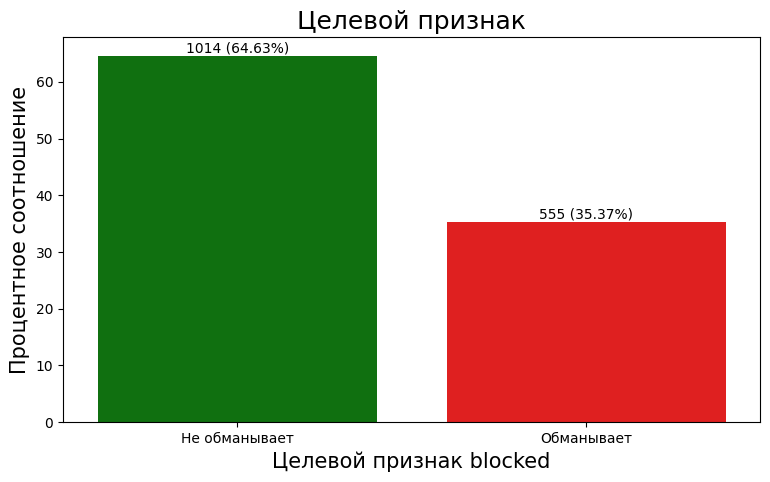

Время выполнения: 0.21 секунд(ы)


In [26]:
# вызов метода target_countplot класса EDA
eda.target_countplot(dataset=final, target_name="blocked")

Дисбаланс терпимый 65 на 35%.

### Описательная статистика

In [27]:
# вызов метода custom_describe класса EDA
eda.custom_describe(dataset=final)

Описательная статистика.



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
teacher_id,1569.00,190340.85,205014.00,85517.05,458.00,127280.00,205014.00,267762.00,311998.00,-0.43,-0.95
min_lesson_price,1569.00,577.32,500.00,545.76,0.00,0.00,500.00,900.00,4000.00,1.26,3.27
max_lesson_price,1569.00,4875.15,3000.00,17568.79,500.00,2000.00,3000.00,5000.00,600000.00,26.38,848.26
avg_lesson_price,1569.00,1555.00,1406.00,inf,190.38,1033.00,1406.00,1876.00,5424.00,nan,nan
amount_to_pay,1569.00,34104.01,7550.00,60045.61,0.00,1500.00,7550.00,40200.00,577800.00,3.24,14.84
amount_paid,1569.00,724.76,0.00,5105.58,0.00,0.00,0.00,0.00,133200.00,15.88,345.10
lessons_qty,1569.00,112.50,71.00,123.66,1.00,26.00,71.00,152.00,1107.00,2.16,6.70
pupils_unique,1569.00,54.76,40.00,51.50,1.00,17.00,40.00,74.00,434.00,1.90,5.14
planned_lesson_number,1569.00,1084.20,677.00,1182.43,10.00,247.00,677.00,1470.00,10380.00,2.11,6.24
lessons_delivered,1569.00,186.11,58.00,343.41,1.00,13.00,58.00,215.00,5690.00,5.41,54.25


Время выполнения: 0.27 секунд(ы)


По описательно статистике есть значение `"money_recieved` в 11162200
Можно наглядно увидеть ниже:

In [28]:
final.loc[final["money_recieved"] == 11162200.00]

,teacher_id,min_lesson_price,max_lesson_price,avg_lesson_price,amount_to_pay,amount_paid,lessons_qty,pupils_unique,planned_lesson_number,diff_amounts,diff_amount_paid_status,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,subject_id_cnt,min_price,max_price,min_price_external,max_price_external,min_price_remote,max_price_remote,teacher_age,teacher_experience,lesson_cost,area_id,review_num,blocked,avg_money_per_pupil
453,139229,0,12000,3494.0,197826.0,9000,1107,434,10380,1,1,5690,2946.0,3788,0.396484,18.125,11162200,6,0,0,3500,4000,3500,4000,57,35,3500,1,67,0,25719.355469


Тут все реально, как и в статистиках по `amount_to_pay`  и  `amount_paid`, а вот `max_lesson_price` в 600000 выглядит аномально...

In [29]:
final.loc[final["max_lesson_price"] == 600000]

,teacher_id,min_lesson_price,max_lesson_price,avg_lesson_price,amount_to_pay,amount_paid,lessons_qty,pupils_unique,planned_lesson_number,diff_amounts,diff_amount_paid_status,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,subject_id_cnt,min_price,max_price,min_price_external,max_price_external,min_price_remote,max_price_remote,teacher_age,teacher_experience,lesson_cost,area_id,review_num,blocked,avg_money_per_pupil
20,9245,0,600000,5424.0,36800.0,0,218,139,1968,1,1,3012,2244.0,2508,0.5,28.1875,5626975,2,5000,5000,9999,9999,4000,4000,36,17,3000,1,80,0,40481.835938


такие значения можно отсечь по 75% квартилю.

In [30]:
final.loc[final["max_lesson_price"] > 5000, "max_lesson_price"] = 5000

### Гистограммы и ящики с усами для числовых признаков

Гистограммы и ящики с усами.



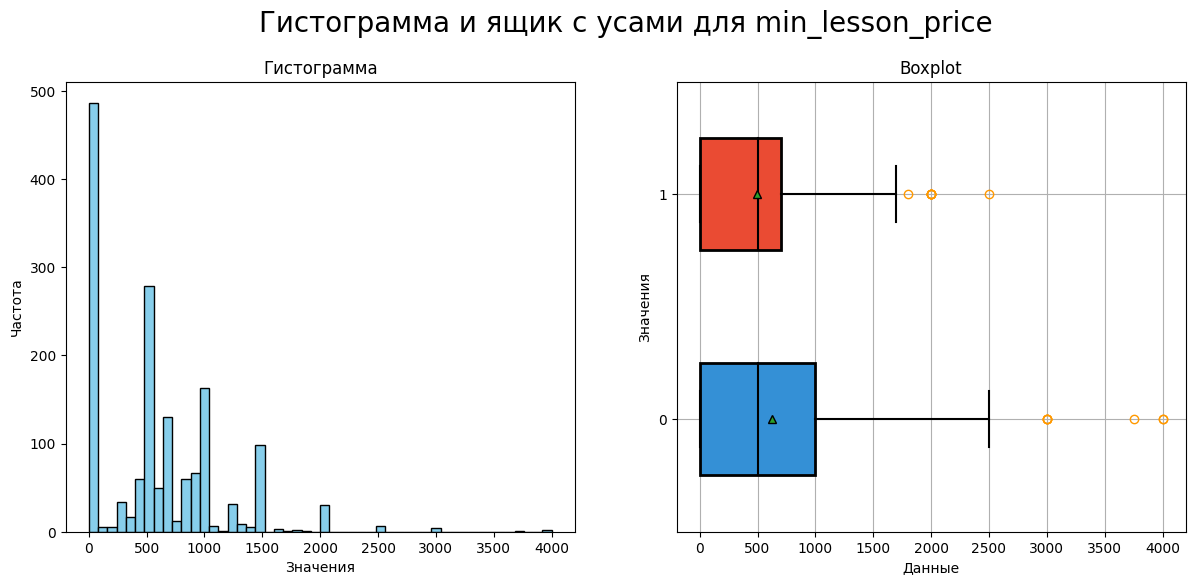

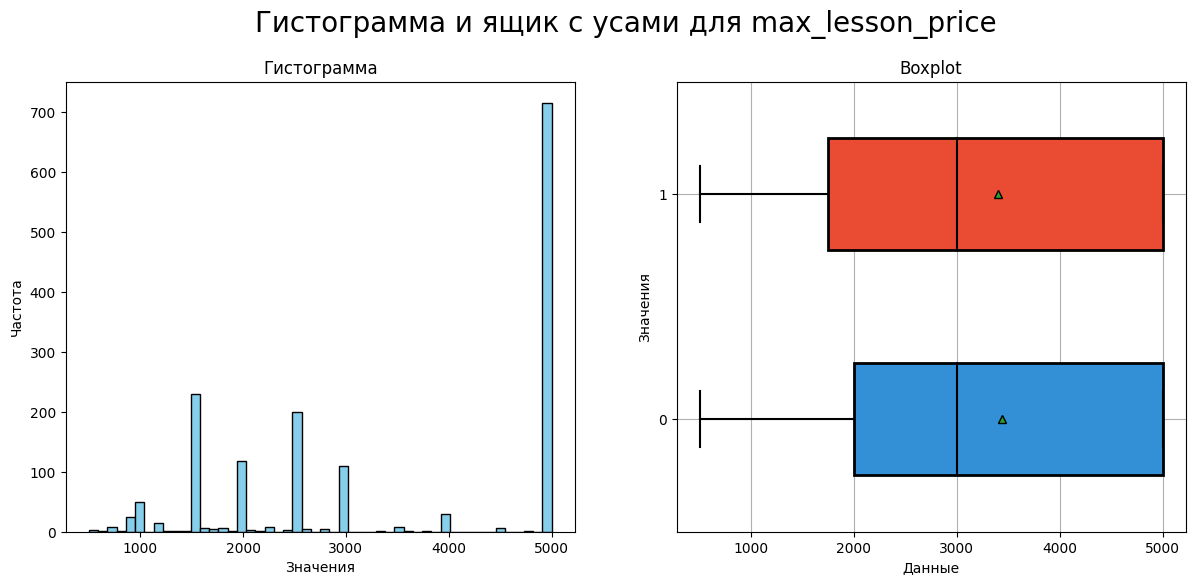

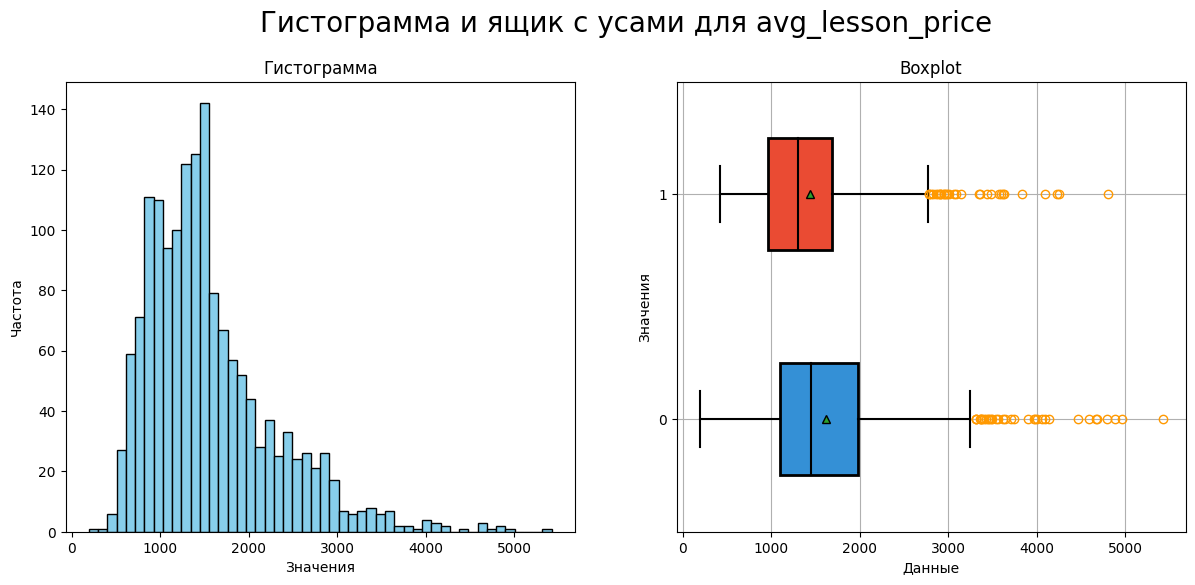

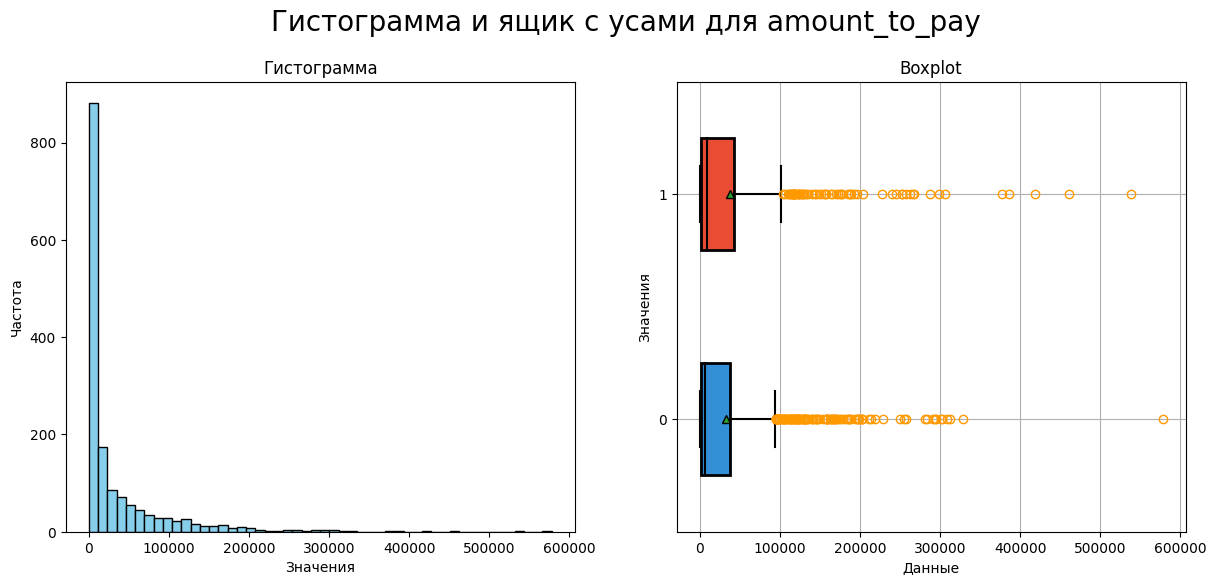

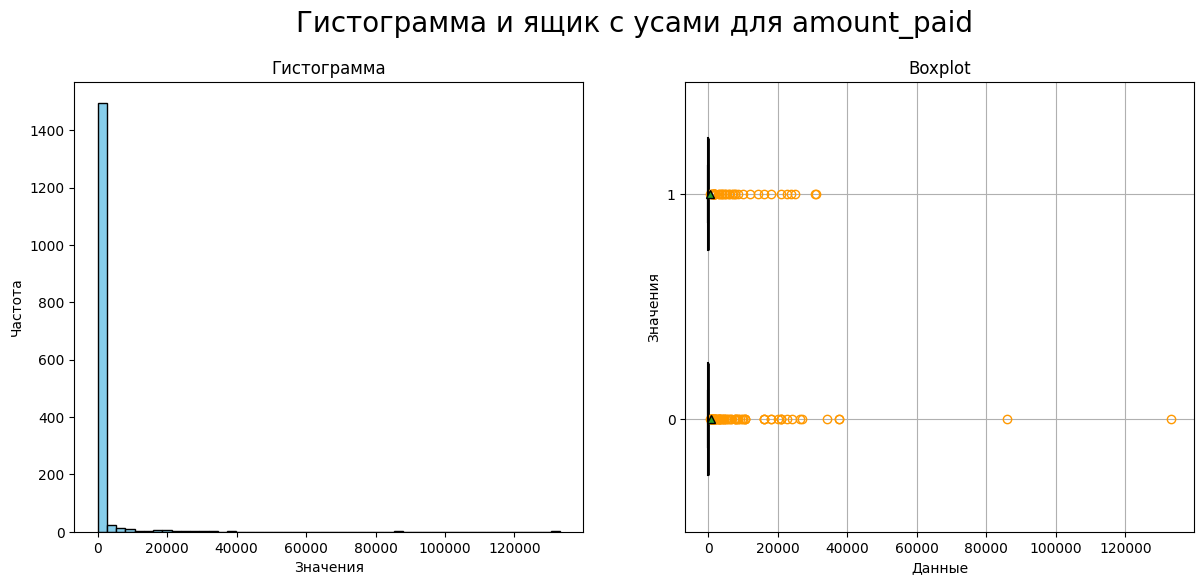

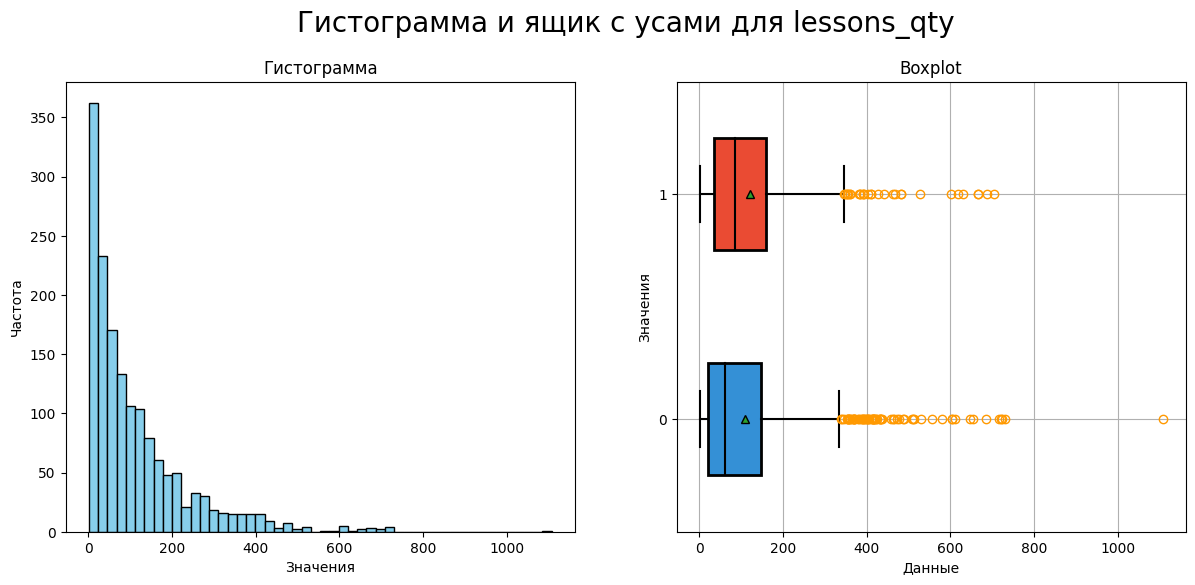

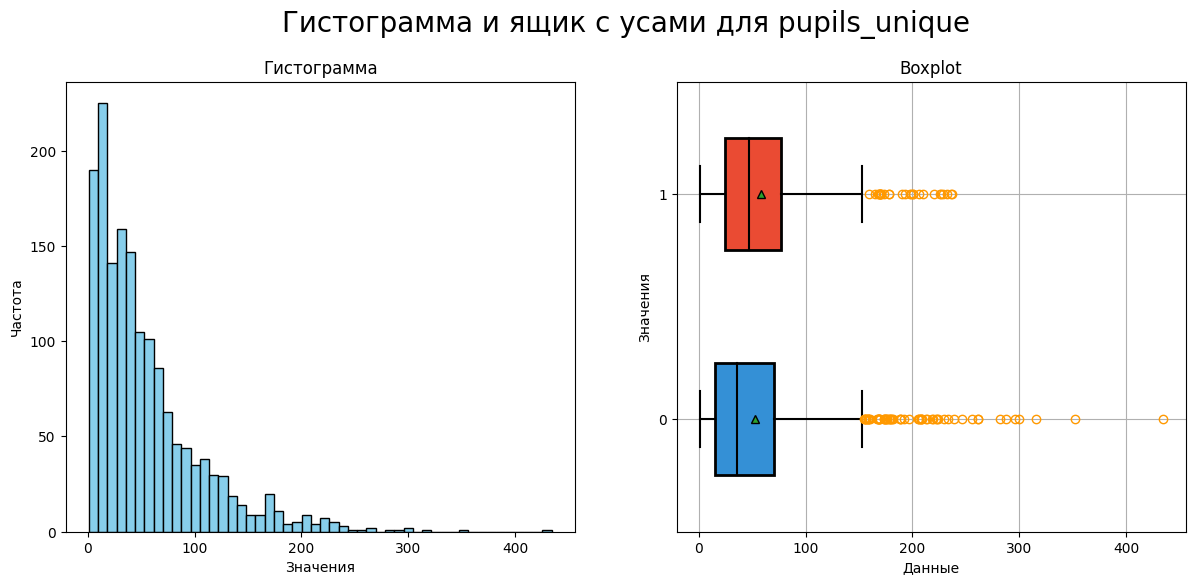

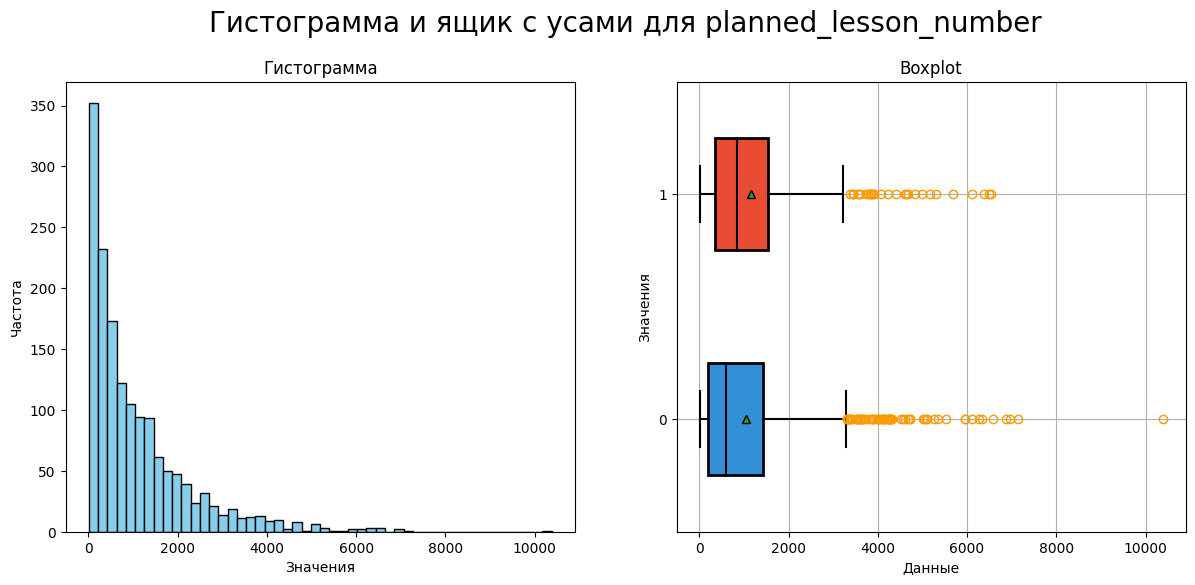

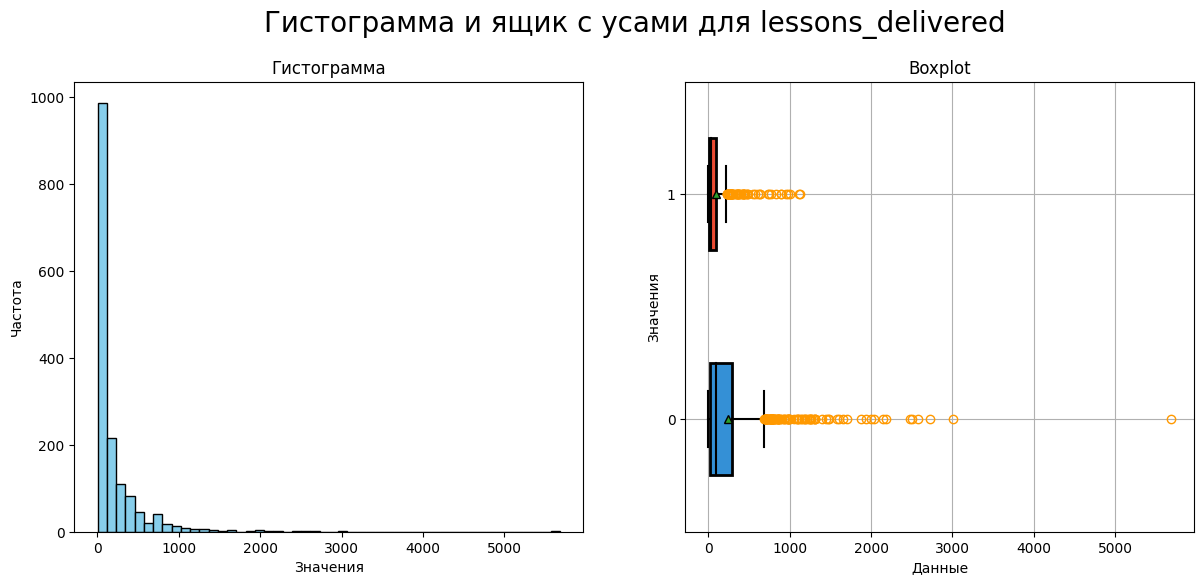

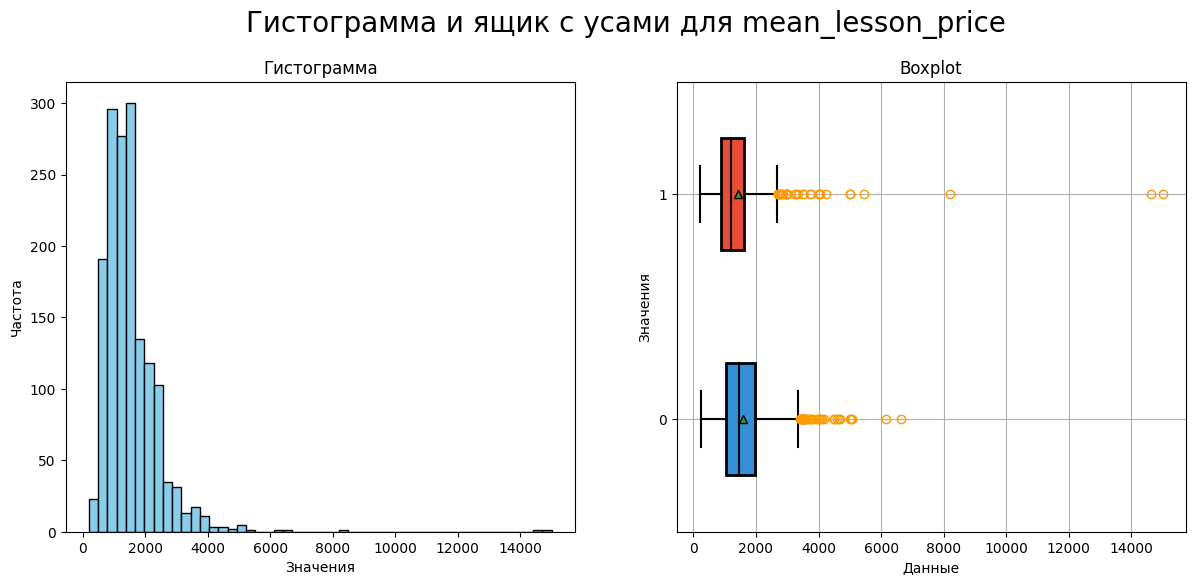

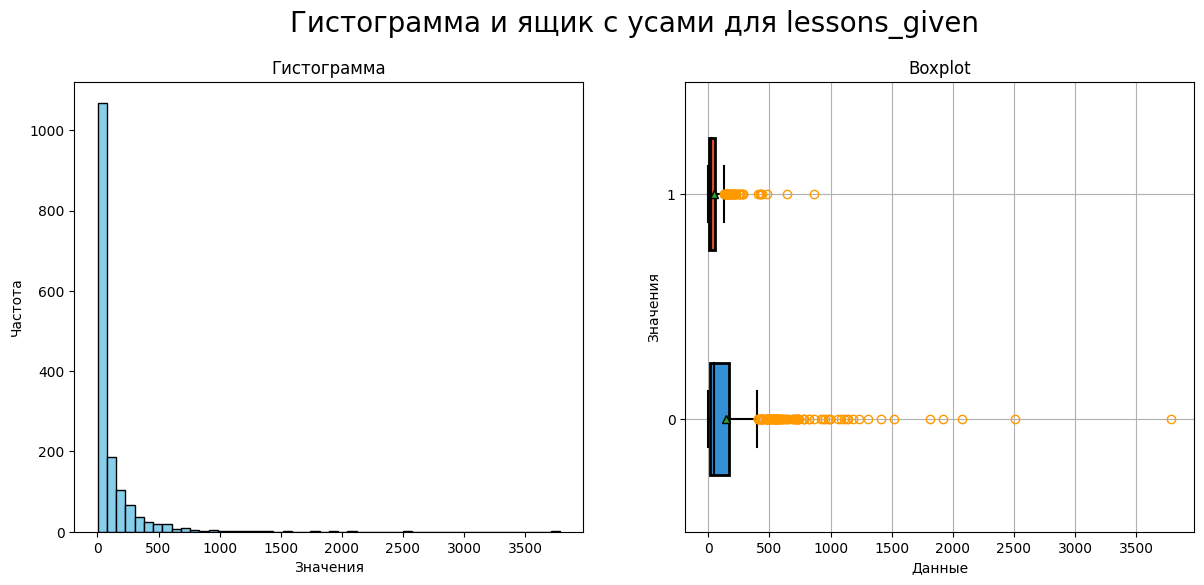

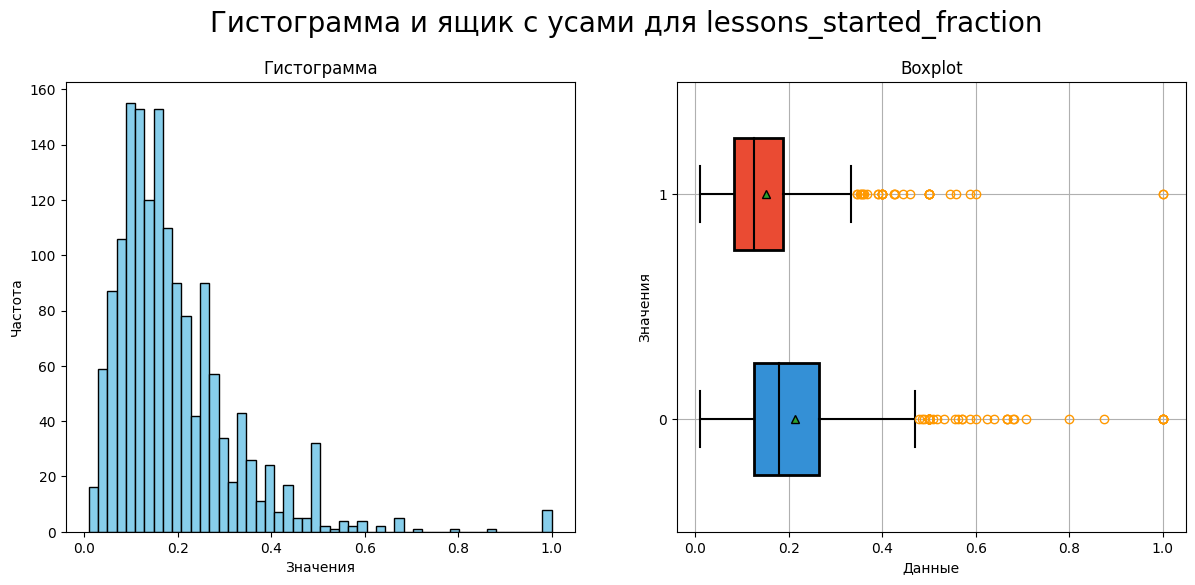

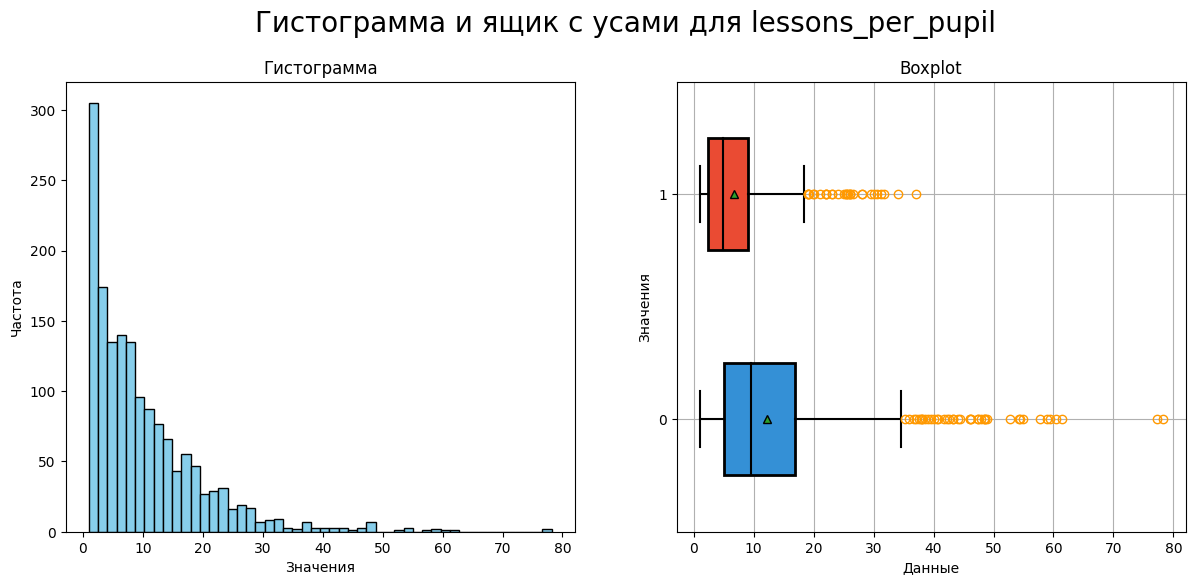

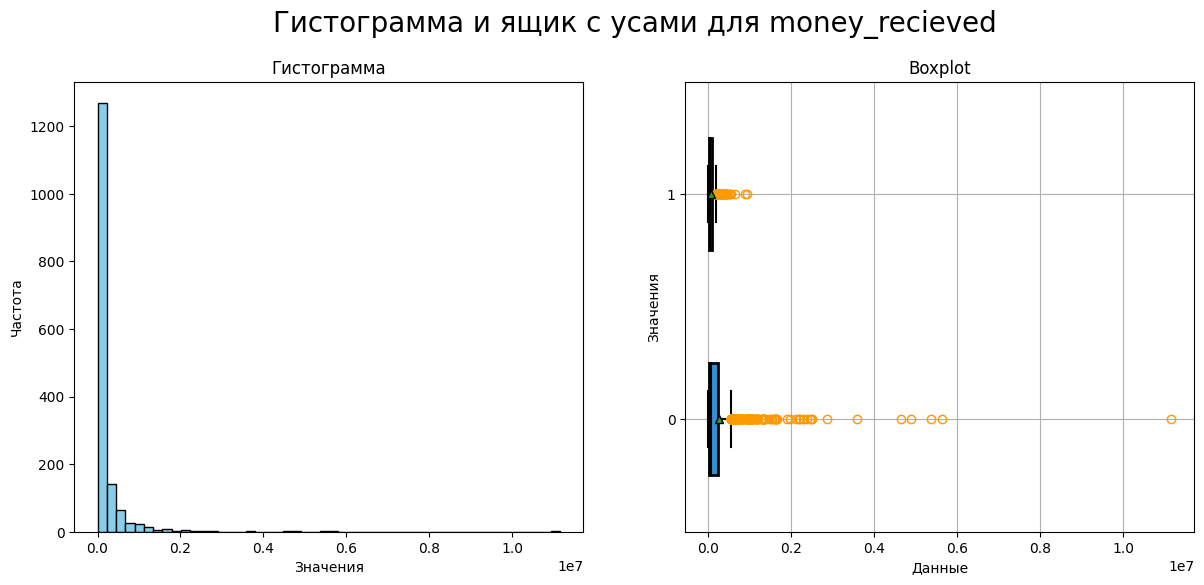

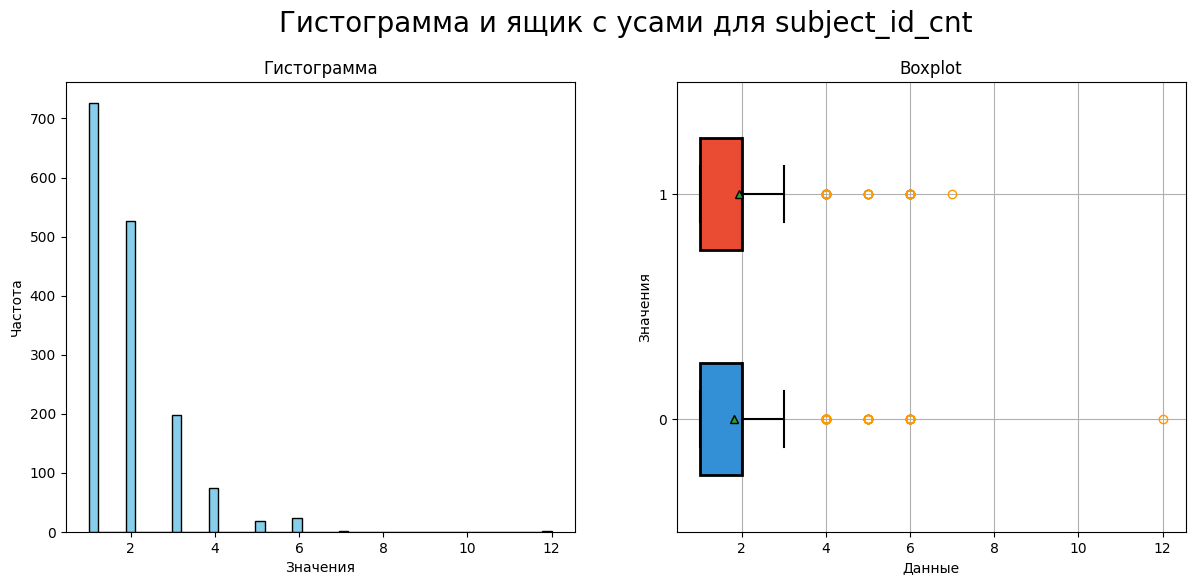

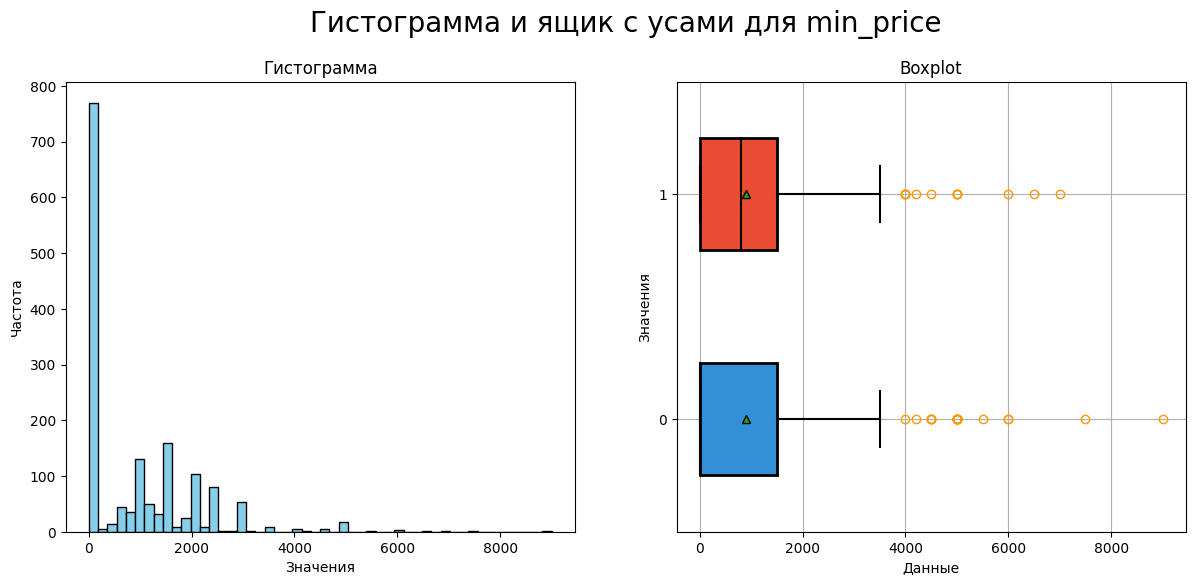

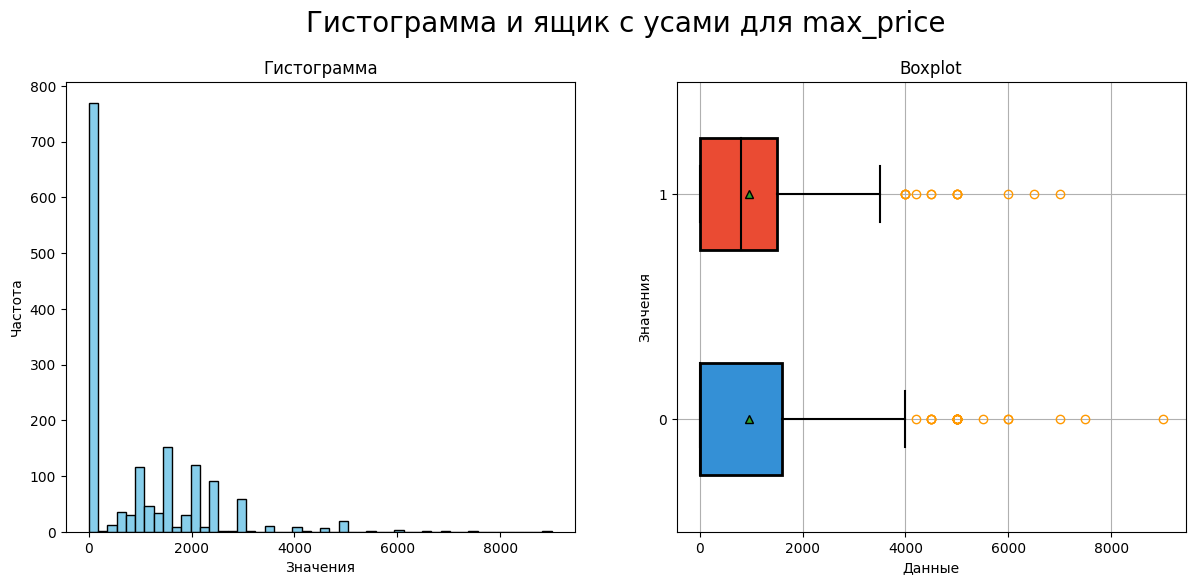

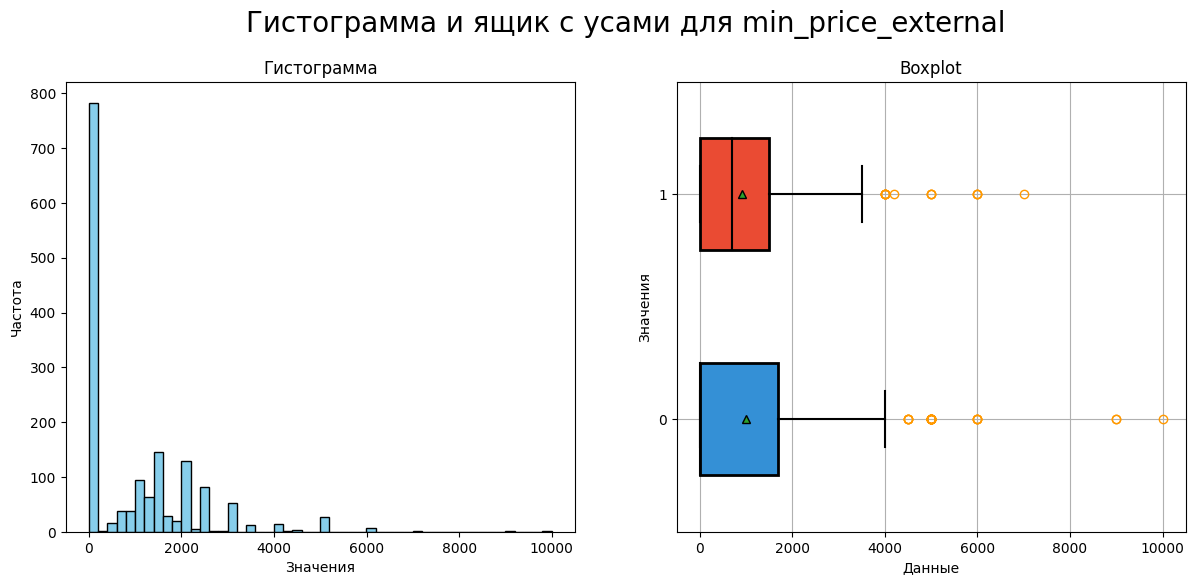

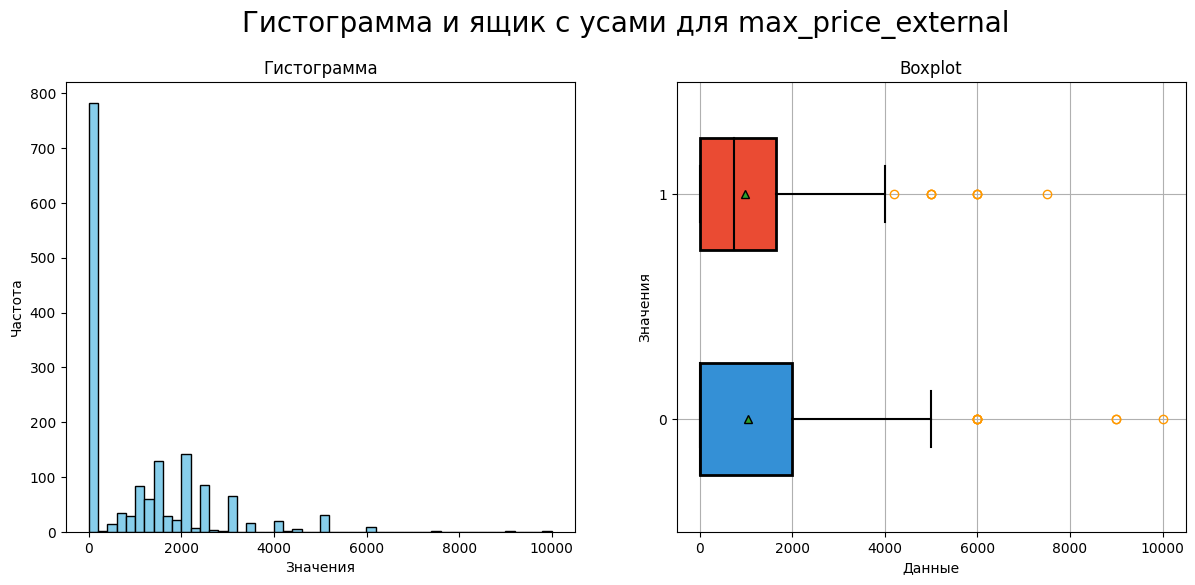

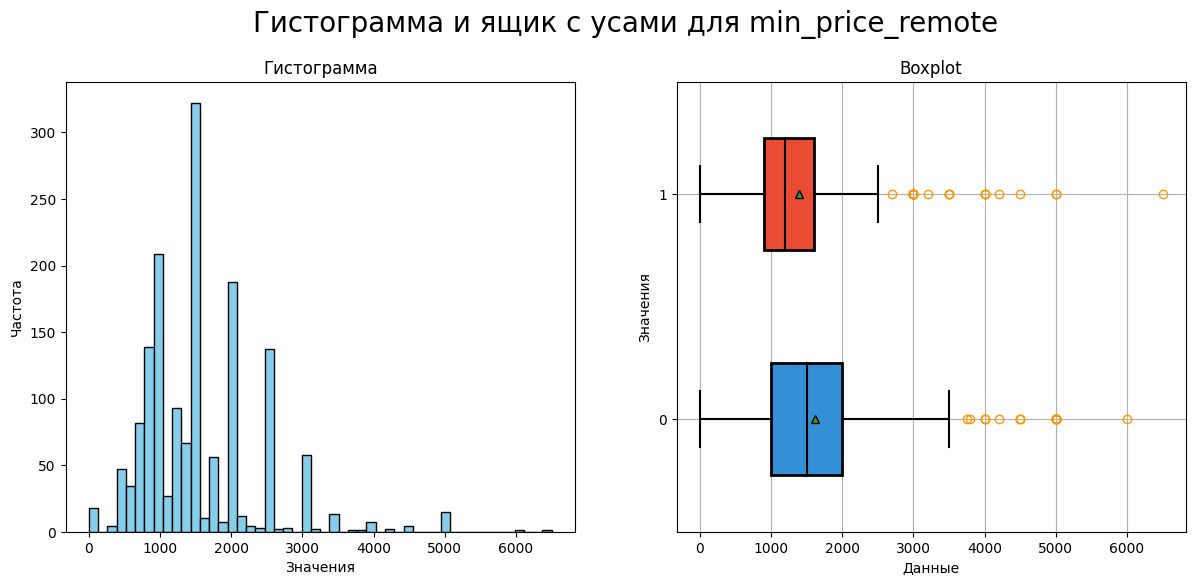

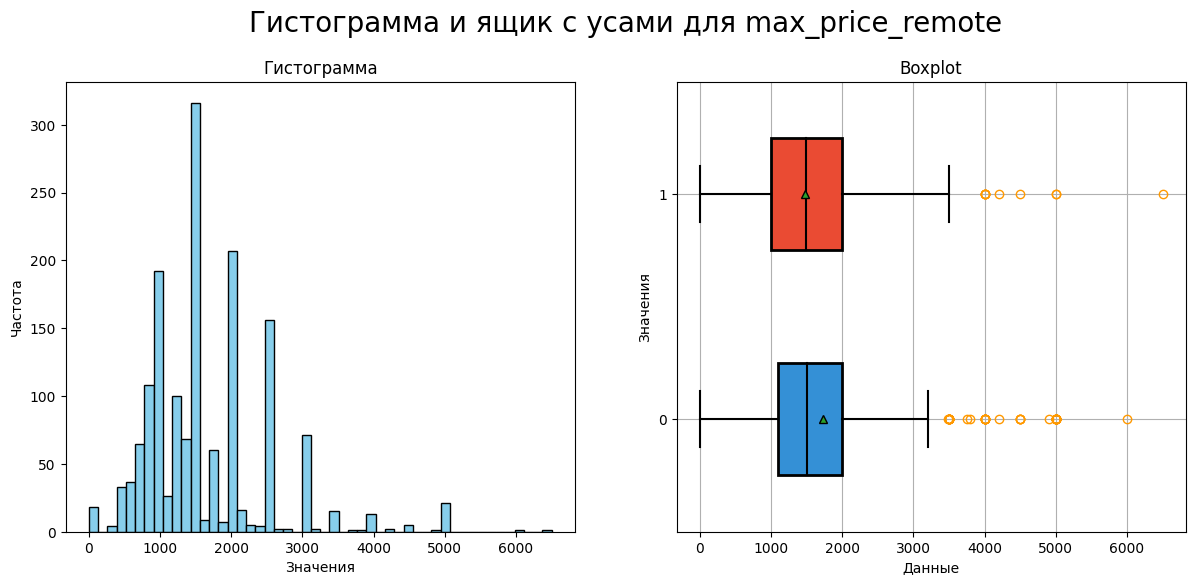

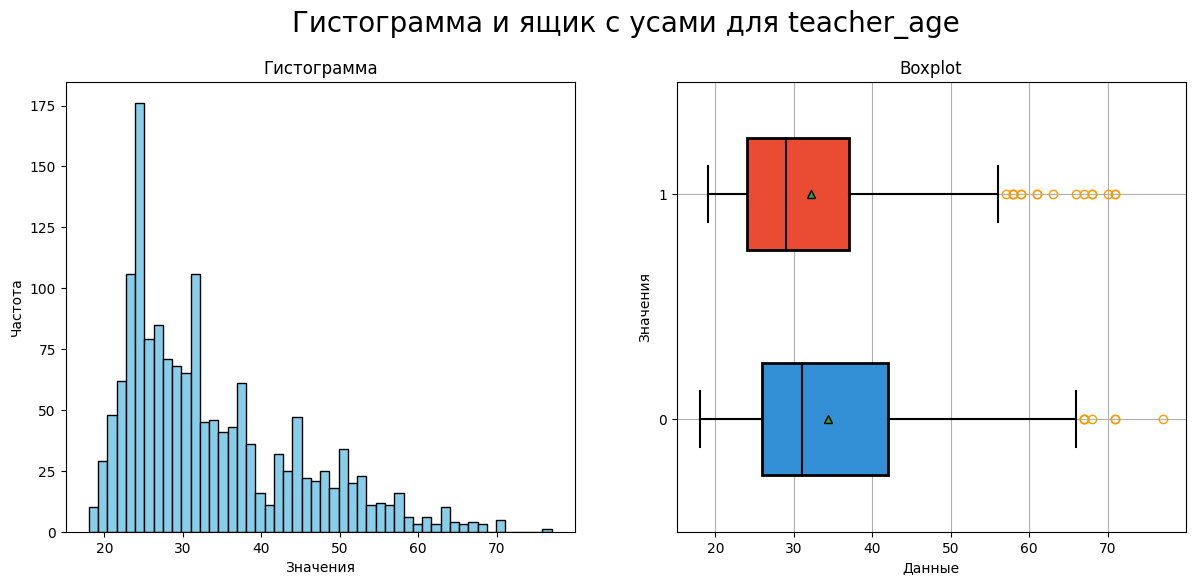

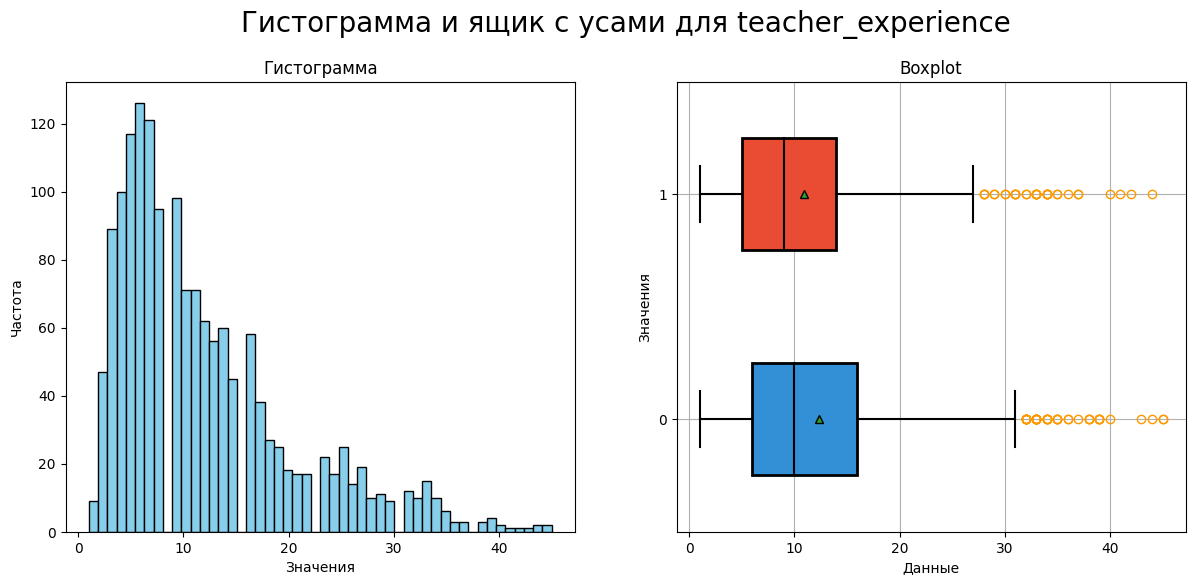

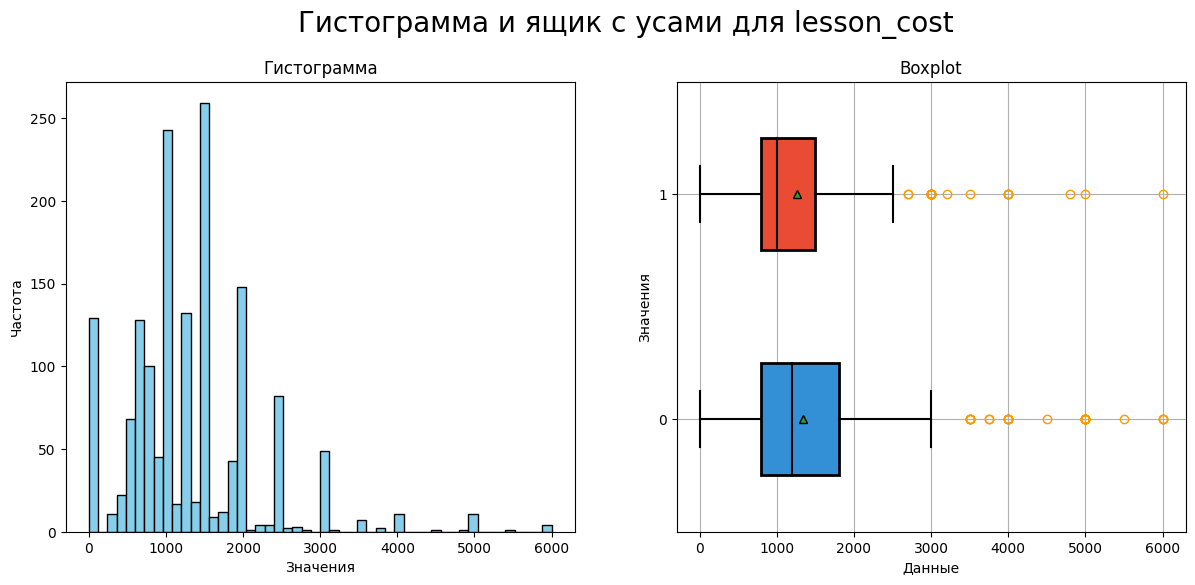

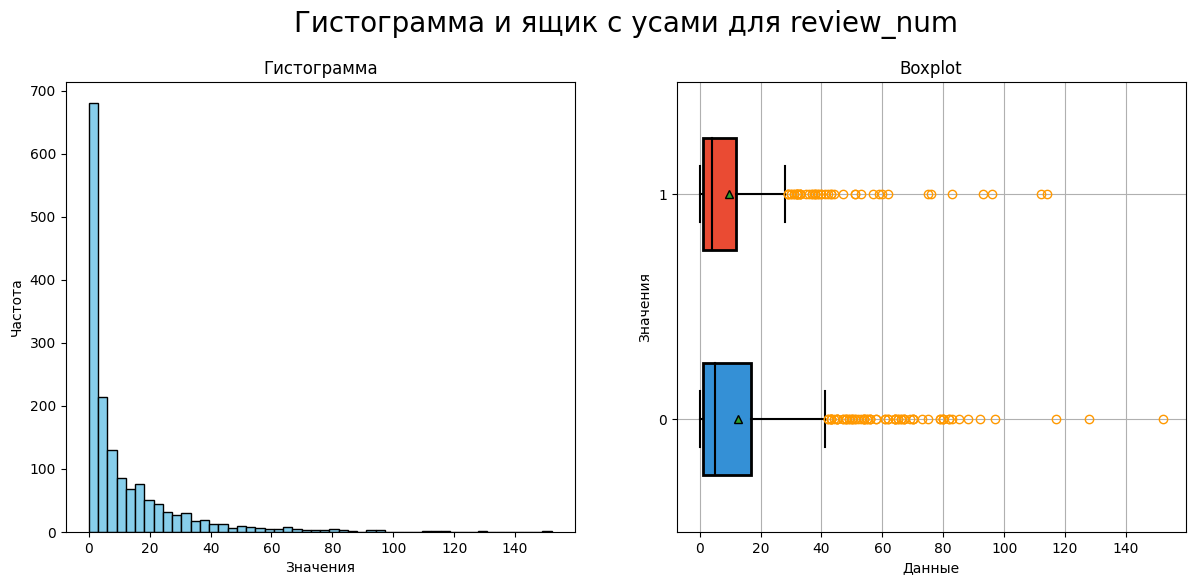

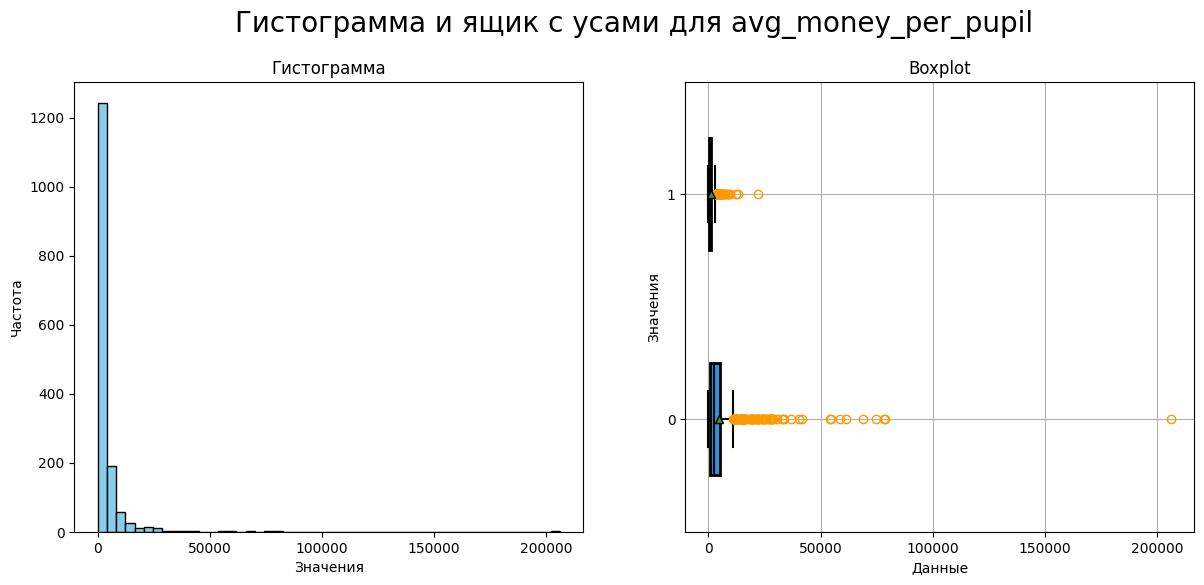

Время выполнения: 10.99 секунд(ы)


In [31]:
# вызов метода hist_and_box класса EDA
eda.hist_and_box(dataset=final, target="blocked", cols_to_drop="teacher_id")

Распределения далеки от нормальных, есть скошенные. По ящикам с усами: практически по всем признакам есть выбросы, но тут я ничего с ними поделать не могу. Принимаю как факт реальность данных и соответсвенно то, что все значения реальные и имеют место быть.

### Корреляция

Время выполнения: 5.06 секунд(ы)


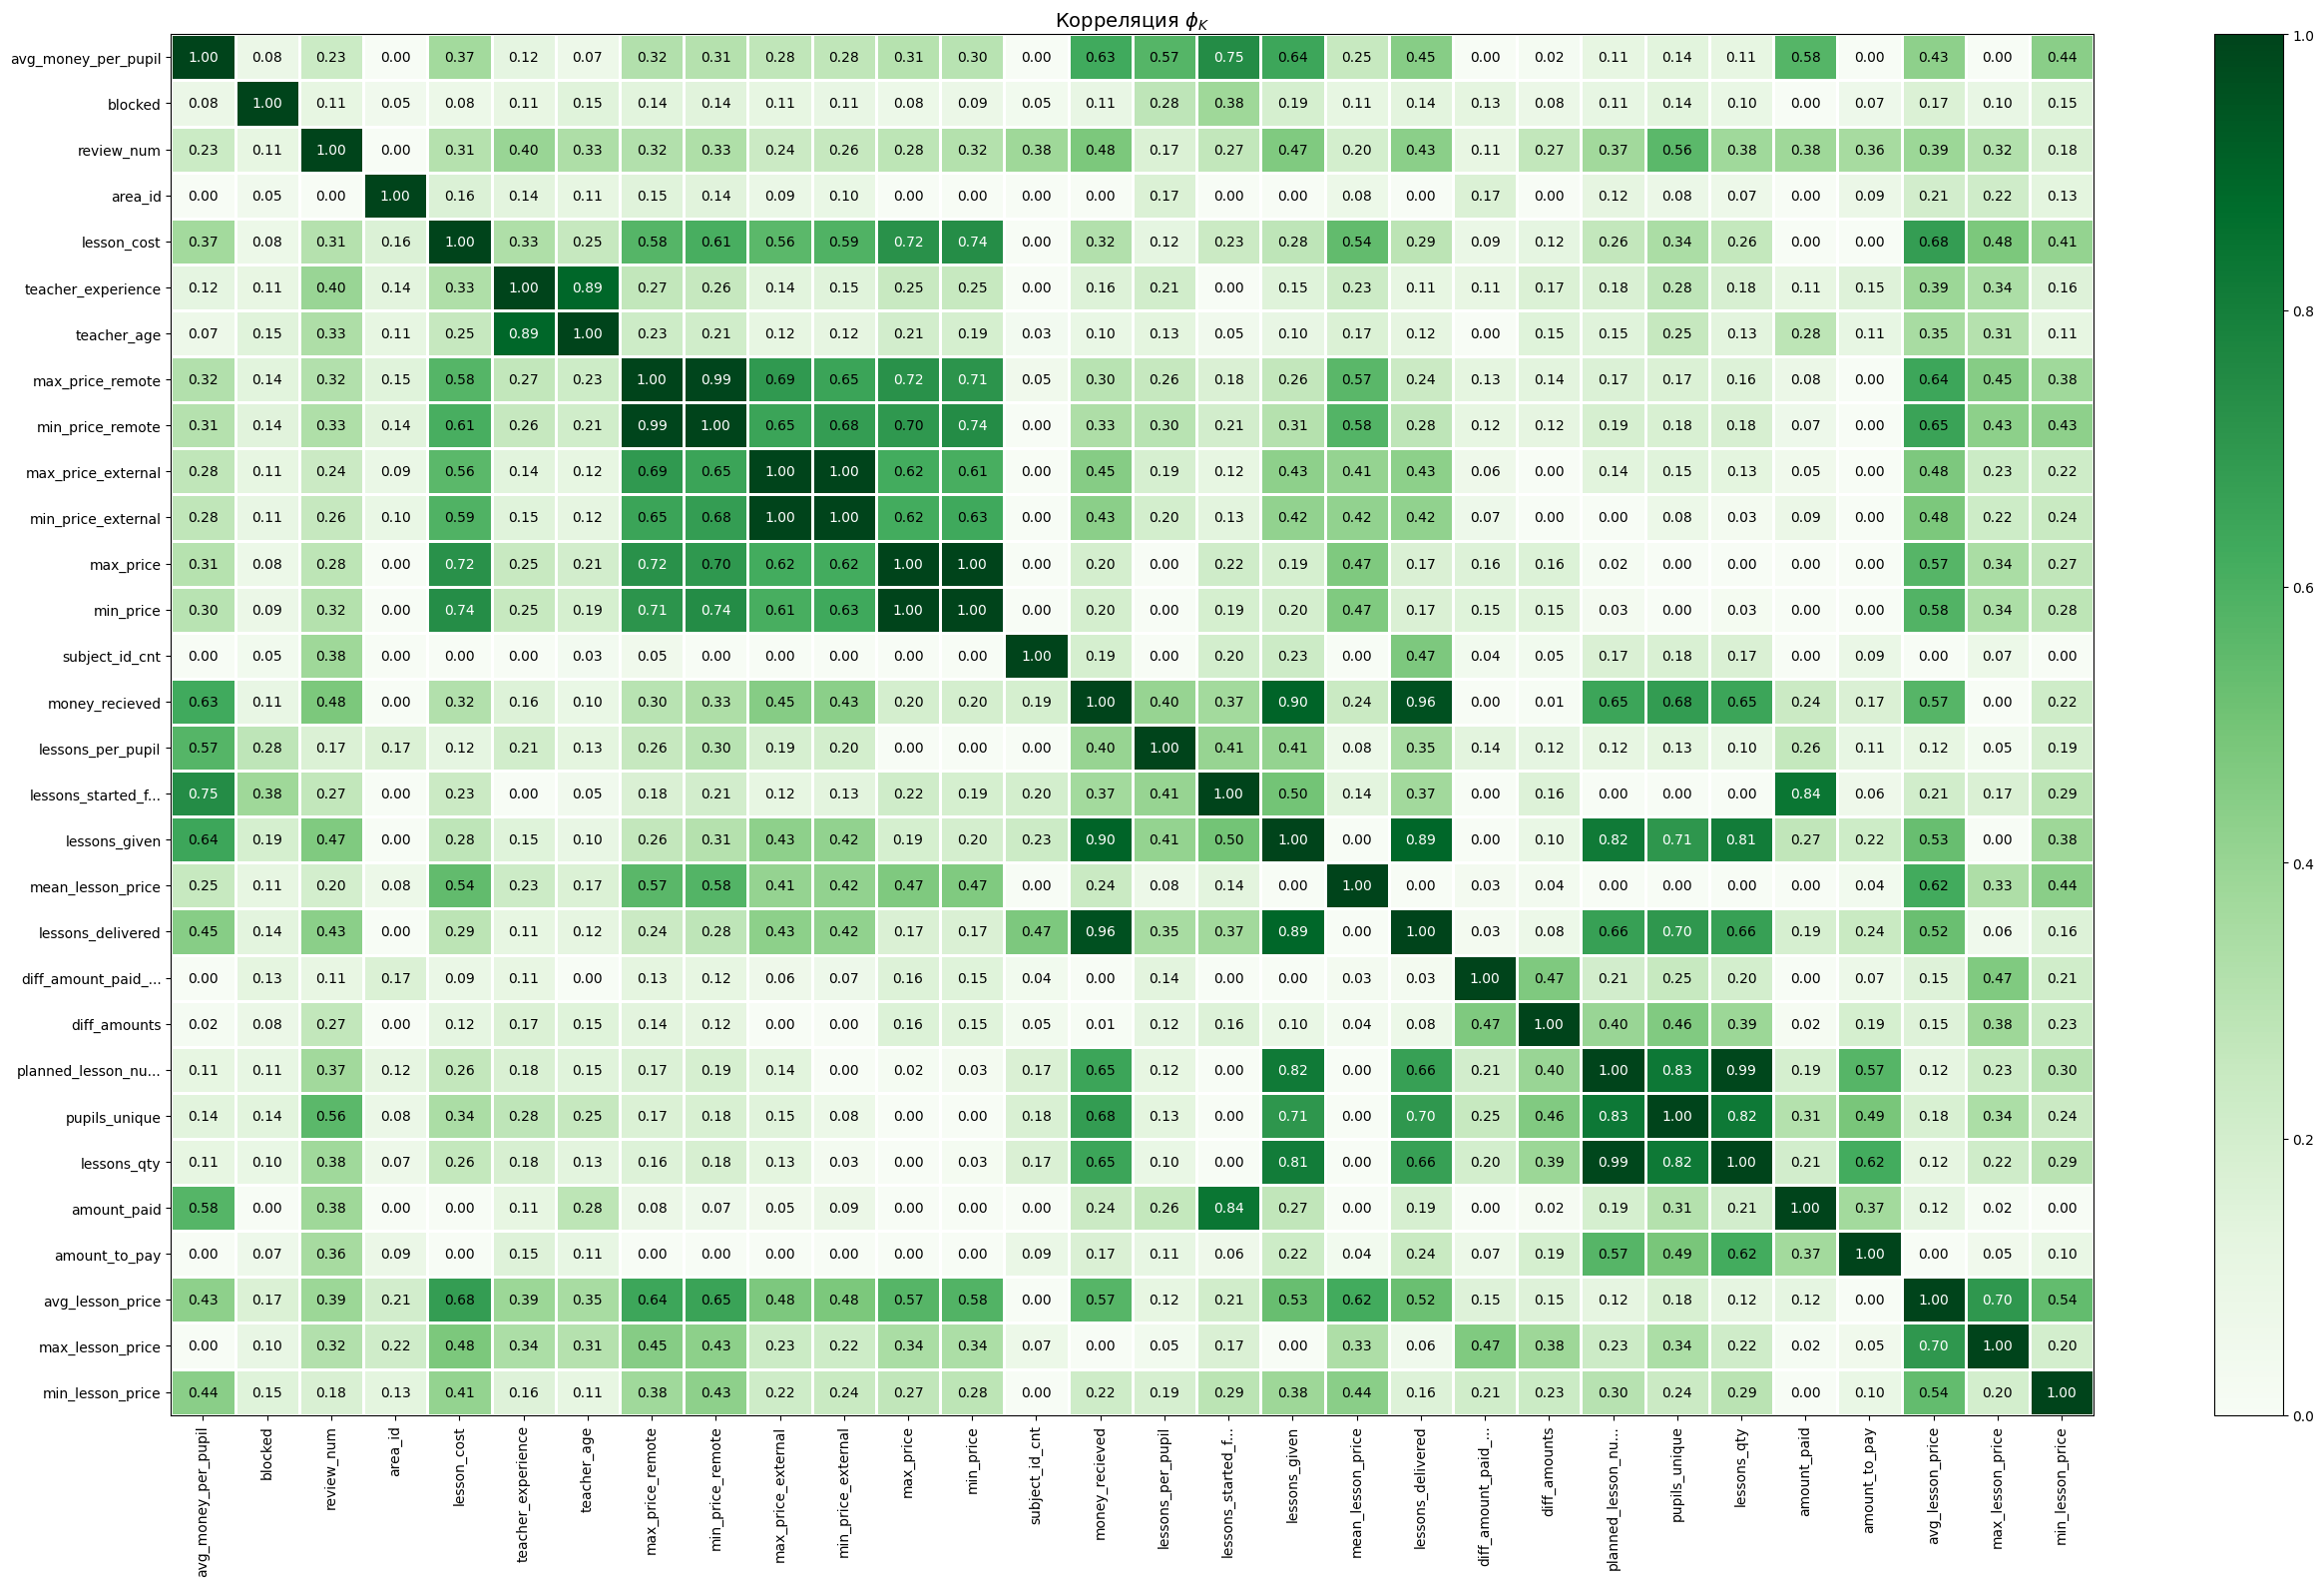

In [32]:
_ = eda.phik_correlation(dataset=final, cols_to_drop=["teacher_id"])

Видна мультиколлинеарность у некоторых признаков.

При помощи параметра `multi_collinear=True` из из метода `phik_correlation` уберем часть признаком и оставим из пары только тот признак, который имеет большее влияние на таргет.

Время выполнения: 3.49 секунд(ы)


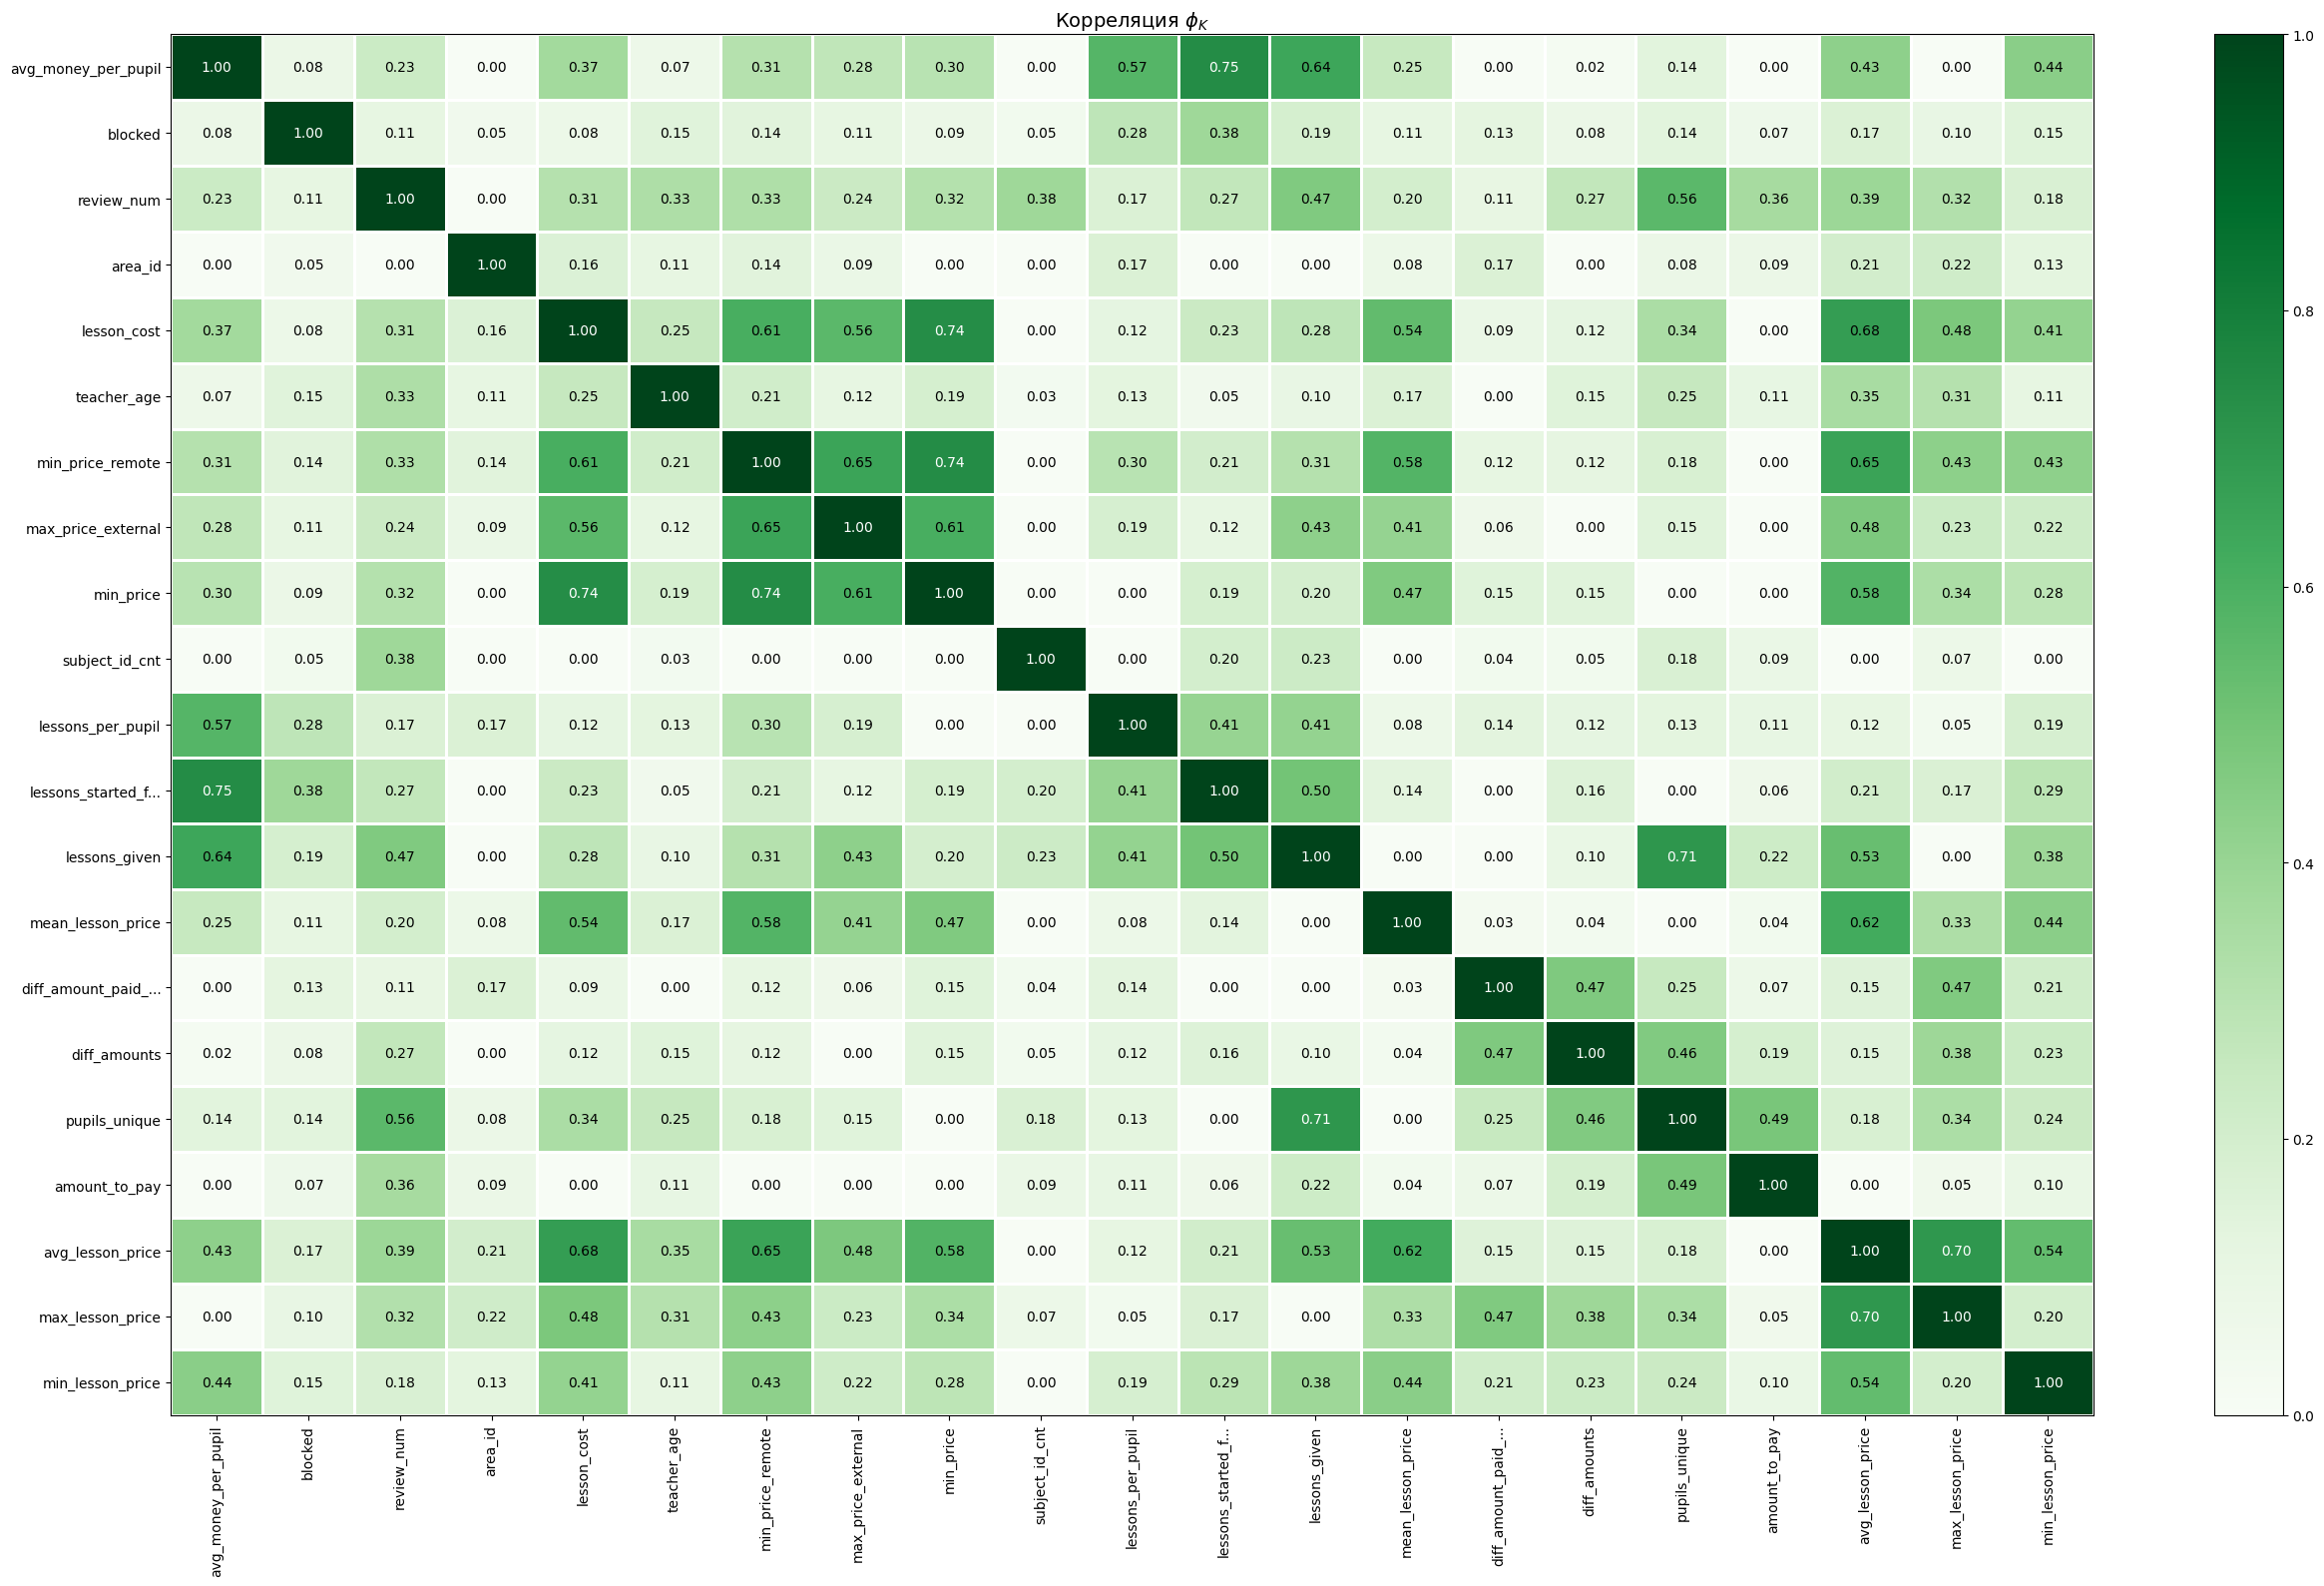

In [33]:
final = eda.phik_correlation(dataset=final, cols_to_drop=["teacher_id"], multi_collinear=True, target_name="blocked")

## Разбиение на выборки

In [34]:
features_train, target_train, features_test, target_test = splitter.get_coded_data(
        dataset=final,
        target_col="blocked",
        cols_to_drop="teacher_id",
        test_size=0.2,
        categorical=True,
        encoder=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)

Время выполнения: 0.03 секунд(ы)


## Модели

### Модель `LGBMClassifier` с дефолтными гипермараметрами без кроссвалидации с балансировкой.

In [35]:
# инициализация модели вызовом метода get_model класса ModelOptuna
model_lgbm = ModelOptuna.get_model(
    model_name="LGBMClassifier",
    fixed_params={"force_row_wise": True, "verbose": -1, "class_weight": "balanced"},
    random=RANDOM,
)

In [36]:
# обучение модели и получение метрики на тесте вызовом метода get_test_results класса ModelOptuna
# прочерки ставлю, чтобы не сохранять данные в переменные, т.к. они не пригодятся в дальнейшем
_, _, _, _ = modelling.get_test_results(
    model=model_lgbm,
    features_train=features_train,
    target_train=target_train,
    features_test=features_test,
    target_test=target_test,
    metric="f1",
)

Метрика F1 модели на тестовой выборке: 0.696429
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       203
           1       0.69      0.70      0.70       111

    accuracy                           0.78       314
   macro avg       0.76      0.77      0.76       314
weighted avg       0.78      0.78      0.78       314

Время выполнения: 0.18 секунд(ы)


Матрица ошибок



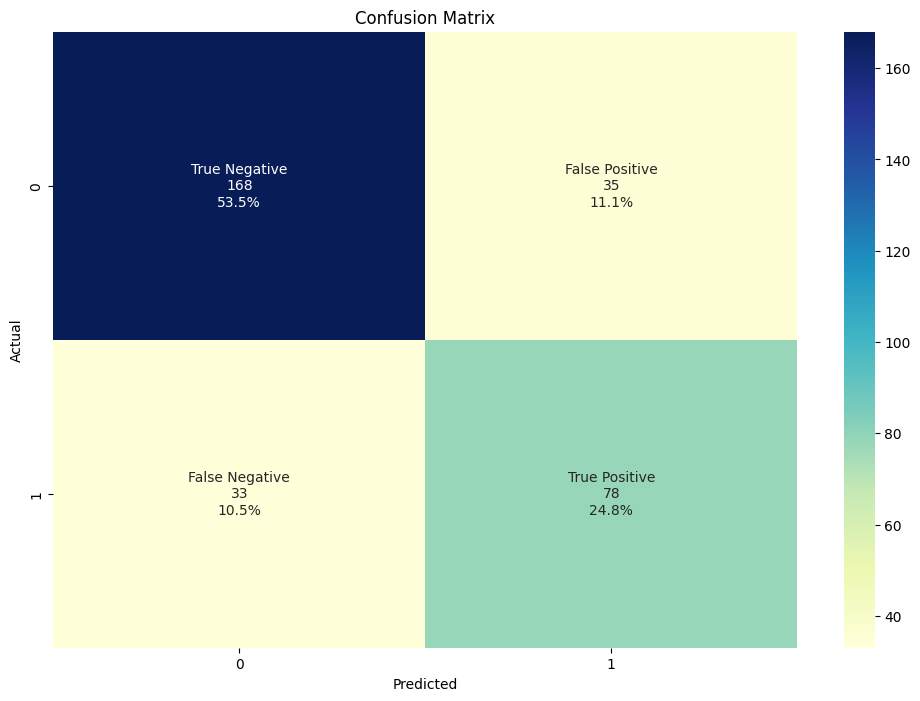

Всего предсказаний: 314

Правильно предсказанные ответы (Accuracy): 0.7834
Ошибки в прогнозах: 0.2166

Recall: 0.7027
Precision: 0.6903

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 168 правильных ответов.
  - TP в правом нижнем углу. 78 правильных ответов.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 35 ошибок ошибочных предсказаний первого рода.
  - FN в левом нижнем углу. 33 ошибочных предсказаний второго рода.


In [37]:
report.drow_confusion_matrix(
    model=model_lgbm, features=features_test, target=target_test
)

Метрика `F1` по дефолту на тестовой выборке **0.684932**. Можно поробовать увеличить метрику за счет подбора гиперпараметров и с балансировкой `SMOTETOMEK`

### Подбор гиперпараметров для `LGBMClassifier`

In [38]:
# словарь с гиперпараметрами для подбора
params = {
    "boosting_type": ["gbdt", "rf"],
    "n_estimators": [10, 500],
    "max_depth": [1, 25],
    "num_leaves": [2, 25],
    "min_child_weight": [5.01, 30],
    "subsample": [0.5, 1.0],
    "subsample_freq": [1, 10],
    "learning_rate": [0.0001, 1],
    "reg_alpha": [0.1, 10.1],
    "reg_lambda": [0.1, 10.1],
}
# словарь с фиксироваными гиперпараметрами balanced
fixed_params = {
    "objective": "binary",
    "class_weight": "balanced",
    "n_jobs": -1,
    "verbose": -1,
    "force_row_wise": True,
}
# словарь с фиксироваными гиперпараметрами unbalanced
fixed_params_unb = {
    "objective": "binary",
    "n_jobs": -1,
    "verbose": -1,
    "force_row_wise": True,
}

In [39]:
model = modelling.get_model_with_best_params(
    n_trials=150,
    features_train=features_train,
    target_train=target_train,
    model_name="LGBMClassifier",
    fixed_params=fixed_params,
    dynamic_or_best_params=params,
    metric_for_cv="f1",
)

[I 2024-04-01 10:46:28,708] A new study created in memory with name: LGBMClassifier
[I 2024-04-01 10:46:29,860] Trial 0 finished with value: 0.6215783121127533 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 100, 'max_depth': 6, 'num_leaves': 15, 'min_child_weight': 14.546041228859933, 'subsample': 0.9757033722905775, 'subsample_freq': 7, 'learning_rate': 0.09899802946330918, 'reg_alpha': 2.041568994445536, 'reg_lambda': 3.152541219720587}. Best is trial 0 with value: 0.6215783121127533.
[I 2024-04-01 10:46:30,056] Trial 1 finished with value: 0.632965848434775 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 62, 'max_depth': 8, 'num_leaves': 17, 'min_child_weight': 21.344780074325023, 'subsample': 0.9152107567263323, 'subsample_freq': 10, 'learning_rate': 0.07847681841413351, 'reg_alpha': 1.9396663511526442, 'reg_lambda': 2.741622318691845}. Best is trial 1 with value: 0.632965848434775.
[I 2024-04-01 10:46:30,794] Trial 2 finished with value: 0.6178417409996357 and


Лучшие гиперпараметры подобраные Optuna: {'boosting_type': 'gbdt', 'n_estimators': 195, 'max_depth': 14, 'num_leaves': 19, 'min_child_weight': 8.825012117522633, 'subsample': 0.7522099886845232, 'subsample_freq': 3, 'learning_rate': 0.029017343024660497, 'reg_alpha': 0.6976261341765203, 'reg_lambda': 1.5043345623017719}
Усредненная метрика f1 модели на тренировочной выборке с кроссвалидацией: 0.6480021918318122
Время выполнения: 202.69 секунд(ы)


In [40]:
best_model, _, _, _ = modelling.get_test_results(
    model=model,
    features_train=features_train,
    target_train=target_train,
    features_test=features_test,
    target_test=target_test,
    metric="f1"
)

Метрика F1 модели на тестовой выборке: 0.718367
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       203
           1       0.66      0.79      0.72       111

    accuracy                           0.78       314
   macro avg       0.76      0.78      0.77       314
weighted avg       0.80      0.78      0.78       314

Время выполнения: 0.27 секунд(ы)


Матрица ошибок



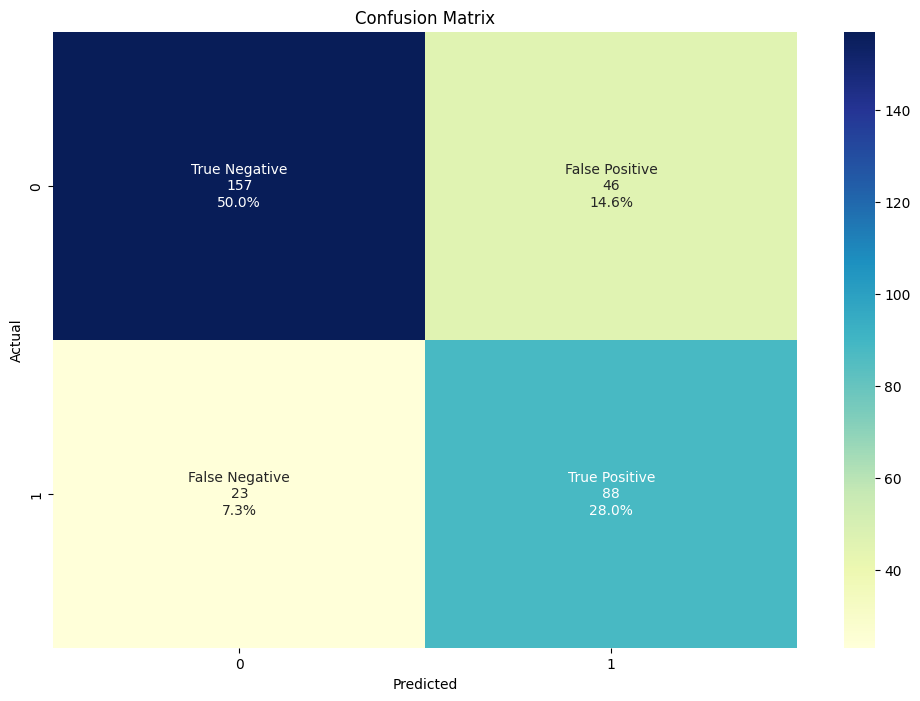

Всего предсказаний: 314

Правильно предсказанные ответы (Accuracy): 0.7803
Ошибки в прогнозах: 0.2197

Recall: 0.7928
Precision: 0.6567

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 157 правильных ответов.
  - TP в правом нижнем углу. 88 правильных ответов.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 46 ошибок ошибочных предсказаний первого рода.
  - FN в левом нижнем углу. 23 ошибочных предсказаний второго рода.


In [41]:
report.drow_confusion_matrix(
    model=best_model, features=features_test, target=target_test
)

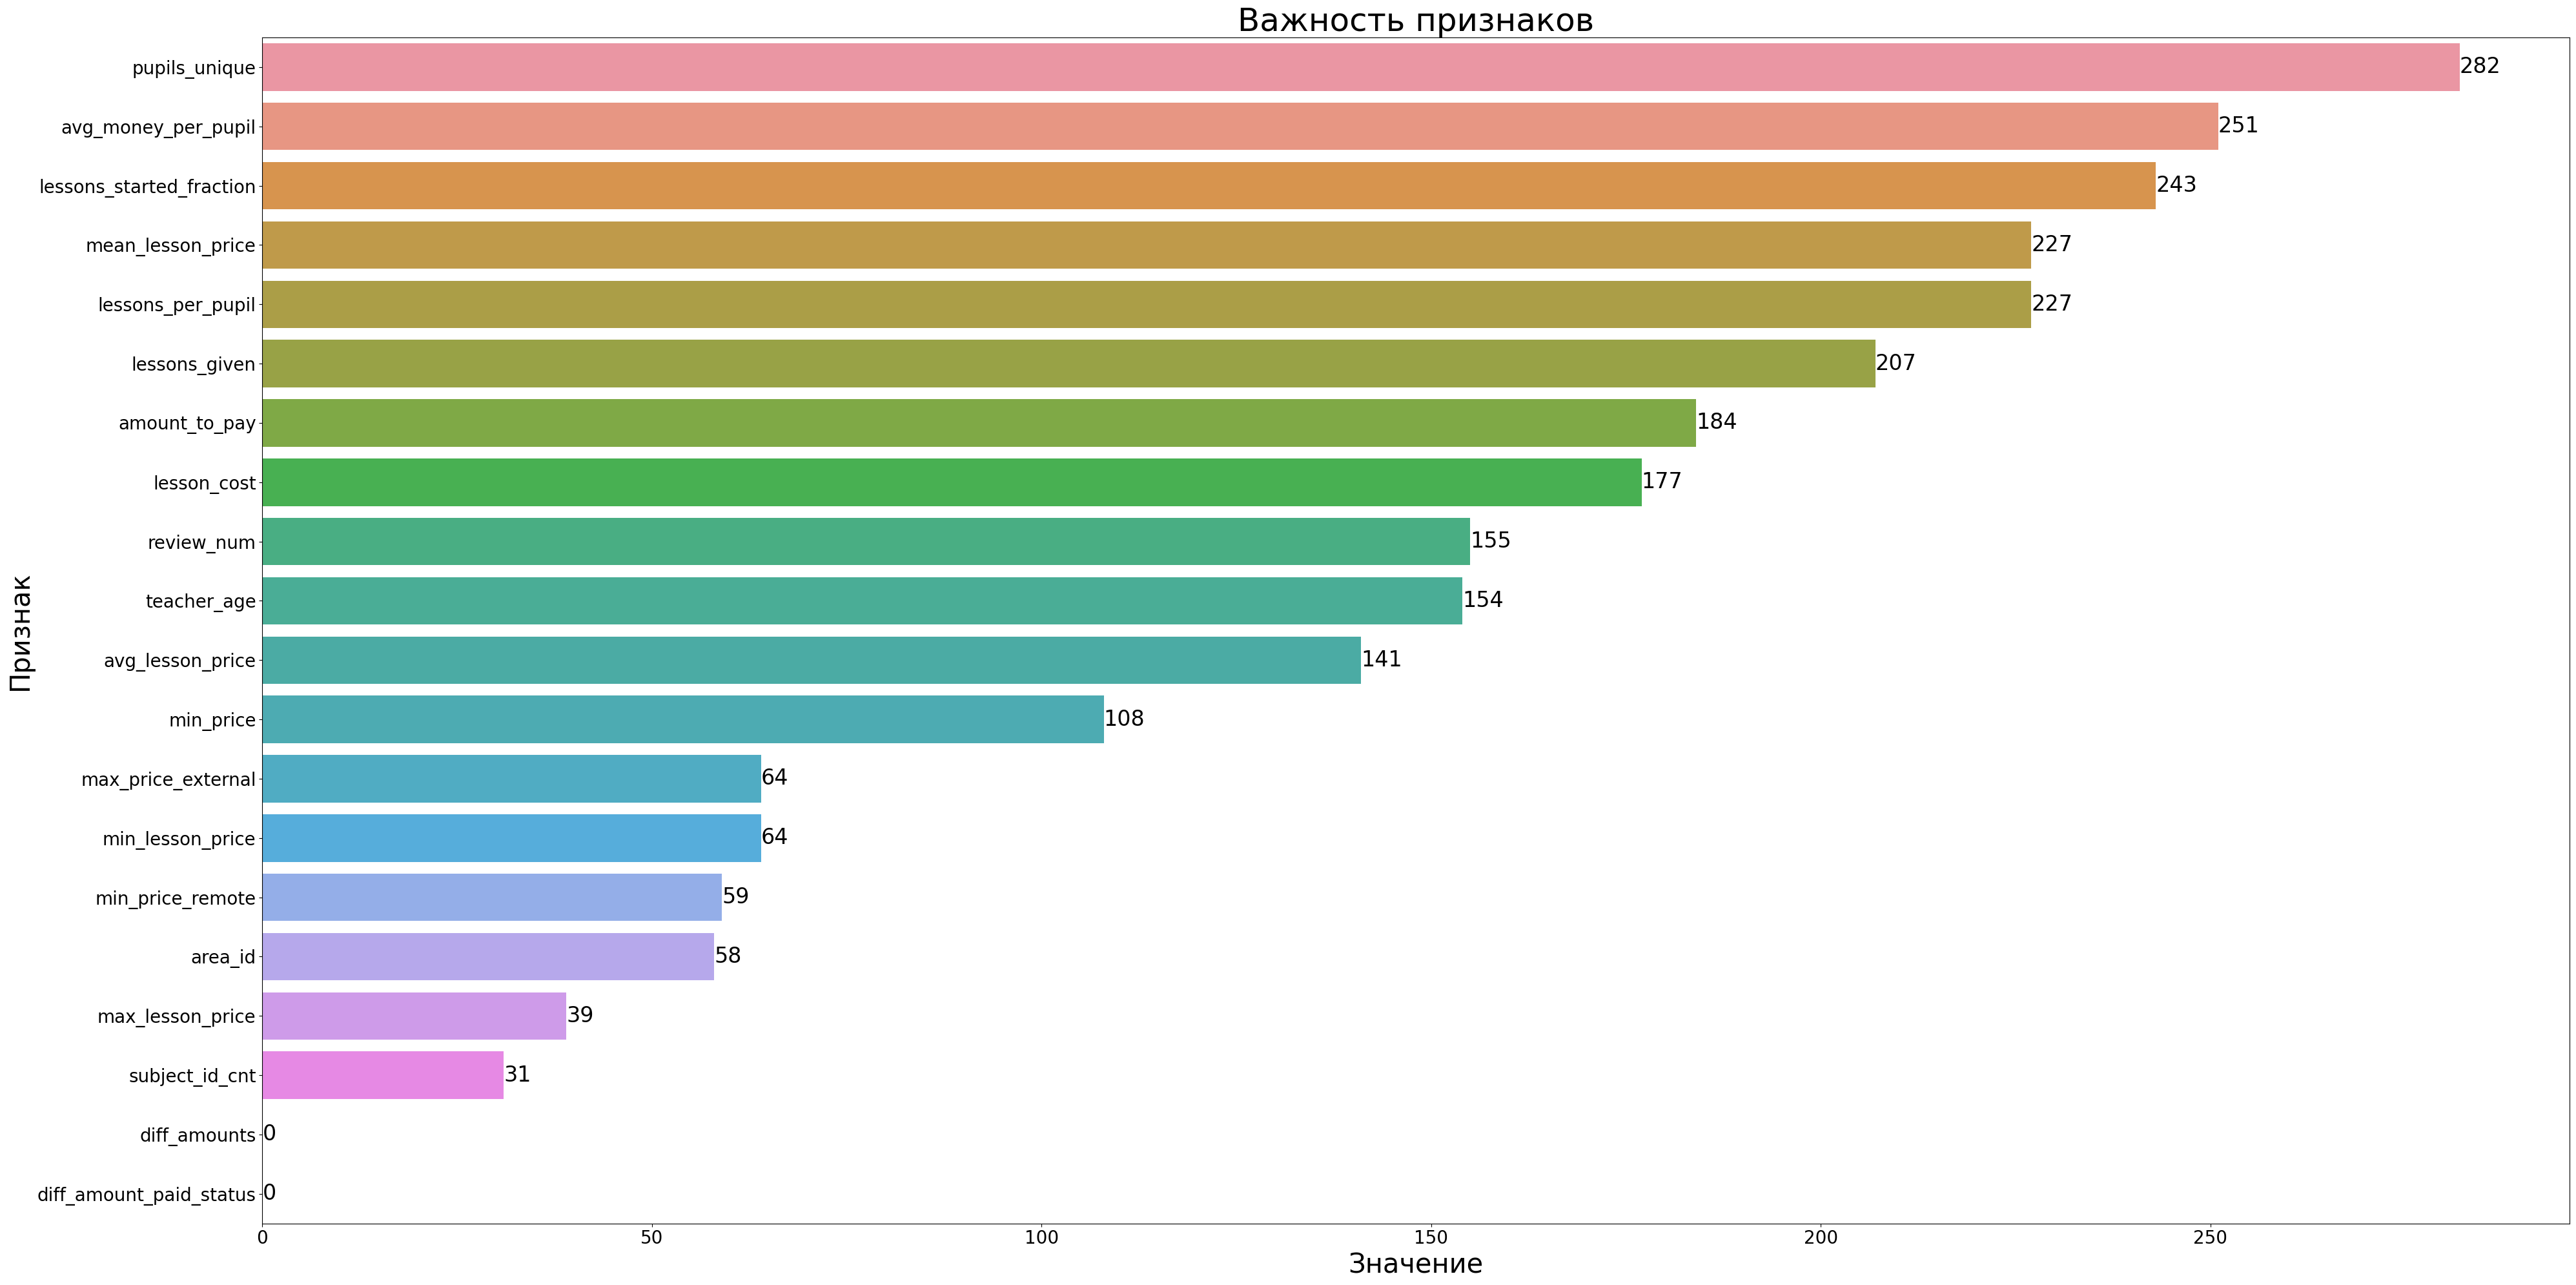

In [42]:
# выводим важность признаков, вызывая метод plot_importance класса GraphicReport
report.plot_importance(
    model=best_model, features=features_train, fig_size=(40, 20)
)

Удалось увеличить метрику до **0.718367**. 

По важности признаков: в топе два новых сгенерированных признака: `pupils_unique` и `avg_money_per_pupil`.

### `LGBMClassifier` с балансировкой `SMOTETOMEK`

In [43]:
# получаем новые сбалансированные выборки методом oversampling класса ModelOptuna
# балансировка SMOTETOMEK с 10 ближайшими соседями
features_train_smote, target_train_smote = modelling.oversampling(
    features=features_train,
    target=target_train,
    method=SMOTETOMEK(k=10, binary_columns=["diff_amounts", "diff_amount_paid_status"], seed=RANDOM),
)

Время выполнения: 3.88 секунд(ы)


In [44]:
# получаем модель с подобранными оптуной гиперпараметрами c балансировкой Crucio SMOTETOMEK
# вызываем метод get_model_with_best_params класса ModelOptuna
model_lgbm_balanced_smote = modelling.get_model_with_best_params(
    n_trials=150,
    features_train=features_train_smote,
    target_train=target_train_smote,
    model_name="LGBMClassifier",
    fixed_params=fixed_params_unb,
    dynamic_or_best_params=params,
    metric_for_cv="f1",
)

[I 2024-04-01 10:49:56,681] A new study created in memory with name: LGBMClassifier
[I 2024-04-01 10:49:57,107] Trial 0 finished with value: 0.8313430822663639 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 100, 'max_depth': 6, 'num_leaves': 15, 'min_child_weight': 14.546041228859933, 'subsample': 0.9757033722905775, 'subsample_freq': 7, 'learning_rate': 0.09899802946330918, 'reg_alpha': 2.041568994445536, 'reg_lambda': 3.152541219720587}. Best is trial 0 with value: 0.8313430822663639.
[I 2024-04-01 10:49:57,482] Trial 1 finished with value: 0.8202345946633418 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 62, 'max_depth': 8, 'num_leaves': 17, 'min_child_weight': 21.344780074325023, 'subsample': 0.9152107567263323, 'subsample_freq': 10, 'learning_rate': 0.07847681841413351, 'reg_alpha': 1.9396663511526442, 'reg_lambda': 2.741622318691845}. Best is trial 0 with value: 0.8313430822663639.
[I 2024-04-01 10:49:58,250] Trial 2 finished with value: 0.7450611536337094 a


Лучшие гиперпараметры подобраные Optuna: {'boosting_type': 'gbdt', 'n_estimators': 85, 'max_depth': 6, 'num_leaves': 15, 'min_child_weight': 20.06144408762469, 'subsample': 0.9934904679028704, 'subsample_freq': 6, 'learning_rate': 0.12441844040064223, 'reg_alpha': 1.3335409357920078, 'reg_lambda': 0.666317441006826}
Усредненная метрика f1 модели на тренировочной выборке с кроссвалидацией: 0.8385179244604313
Время выполнения: 113.72 секунд(ы)


In [45]:
# обучение модели и получение метрики на тесте вызовом метода get_test_results класса ModelOptuna
best_model_lgbm_balanced_smote, _, _, _ = modelling.get_test_results(
    model=model_lgbm_balanced_smote,
    features_train=features_train_smote,
    target_train=target_train_smote,
    features_test=features_test,
    target_test=target_test,
    metric="f1",
)

Метрика F1 модели на тестовой выборке: 0.724528
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       203
           1       0.62      0.86      0.72       111

    accuracy                           0.77       314
   macro avg       0.76      0.79      0.76       314
weighted avg       0.81      0.77      0.77       314

Время выполнения: 0.17 секунд(ы)


Матрица ошибок



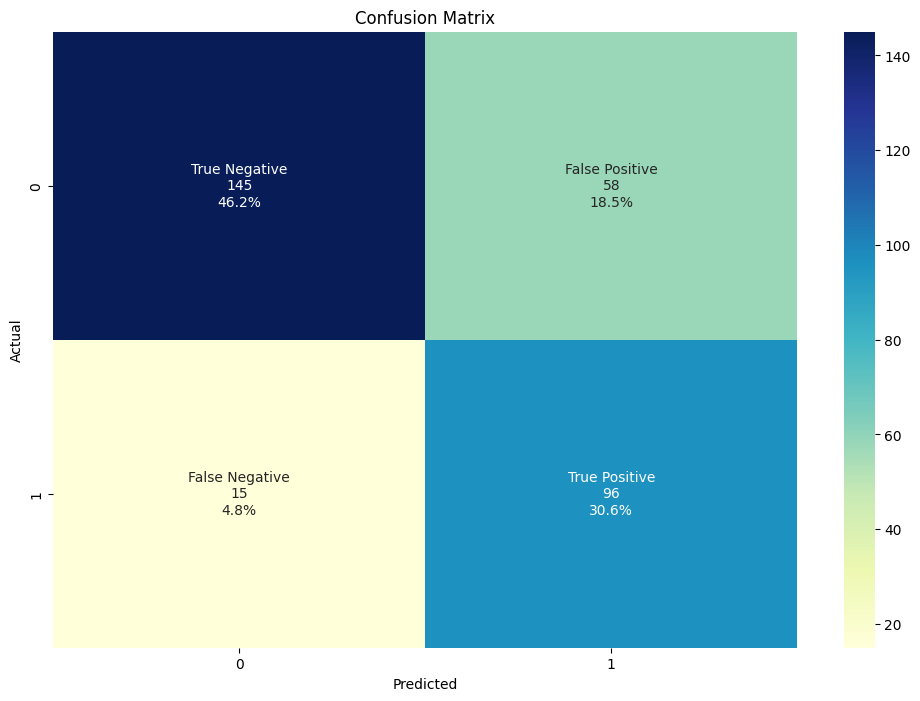

Всего предсказаний: 314

Правильно предсказанные ответы (Accuracy): 0.7675
Ошибки в прогнозах: 0.2325

Recall: 0.8649
Precision: 0.6234

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 145 правильных ответов.
  - TP в правом нижнем углу. 96 правильных ответов.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 58 ошибок ошибочных предсказаний первого рода.
  - FN в левом нижнем углу. 15 ошибочных предсказаний второго рода.


In [46]:
# выводим матрицу ошибок вызовом метода drow_confusion_matrix класса GraphicReport
report.drow_confusion_matrix(
    model=best_model_lgbm_balanced_smote, features=features_test, target=target_test
)

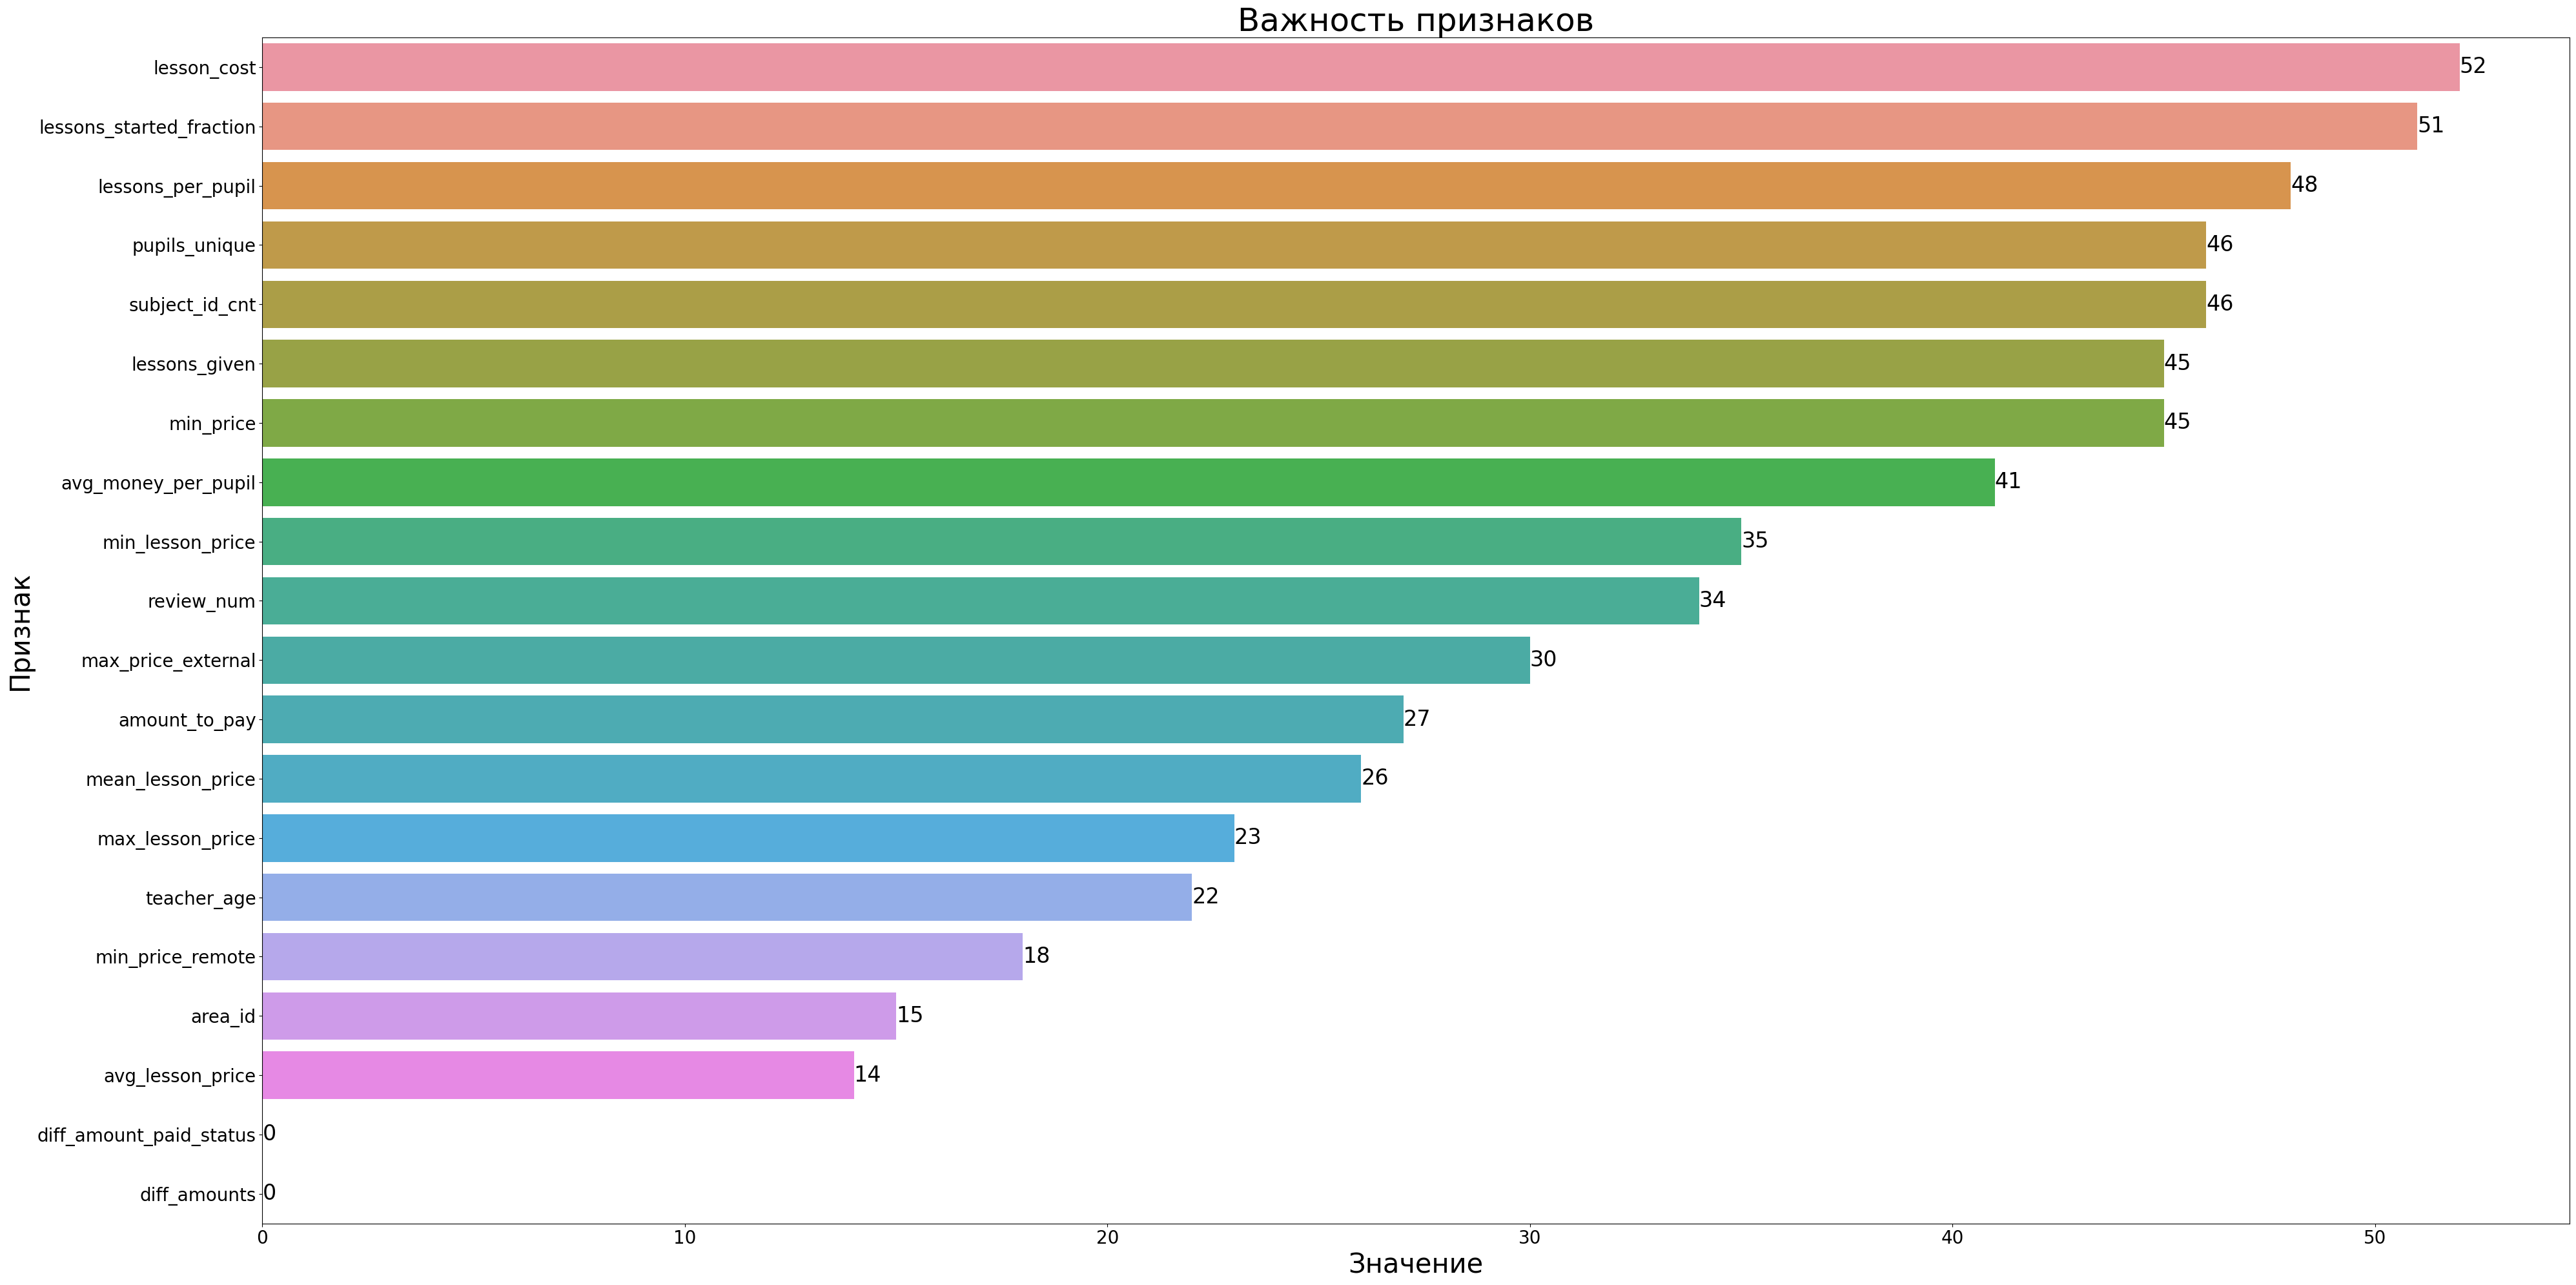

In [47]:
# выводим важность признаков, вызывая метод plot_importance класса GraphicReport
report.plot_importance(
    model=best_model_lgbm_balanced_smote,
    features=features_train_smote,
    fig_size=(40, 20),
)

Балансировкой `SMOTETOMEK` удалось увеличить метрику до **0.724528**, но в данном случае модель становится более заточена на `Recall`, то есть лучше видит единицы. Данный вариант допустим при дополнительной ручной проверке преподавателей.

Отдельно стоит обратить внимание на признаки `diff_amounts`, `diff_amount_paid_status`. Если произвести селективный отбор признаков с упором на `Recall`, то можно увидеть следующую картину. Данные два признака хоть имеют нулевую значимость для `F1`, но могут быть полезны если нужна будет метрика `Recall`.

In [48]:
# получение лучших признаков вызовом метода ential_feature_selection класса ModelOptuna
best_features = modelling.sequential_feature_selection(
    model=model_lgbm,
    features_train=features_train,
    target_train=target_train,
    k_features=1,
    forward=False,
    floating=True,
    verbose=-2,
    scoring="recall",
    cv=5,
    n_jobs=2,
    top_rows=6,
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  19 out of  19 | elapsed:   10.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:    9.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  17 out of  17 | elapsed:    7.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 out of  16 | elapsed:   

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,num_features
0,"(6,)","[0.9438202247191011, 0.9775280898876404, 1.0, 0.9662921348314607, 0.9886363636363636]",0.975255,"(diff_amount_paid_status,)",0.024823,0.019313,0.009657,1
1,"(5, 6)","[0.8539325842696629, 0.8314606741573034, 0.8876404494382022, 0.8764044943820225, 0.8977272727272...",0.869433,"(diff_amounts, diff_amount_paid_status)",0.030755,0.023928,0.011964,2
2,"(5, 6, 8)","[0.6404494382022472, 0.6404494382022472, 0.7078651685393258, 0.6629213483146067, 0.6931818181818...",0.668973,"(diff_amounts, diff_amount_paid_status, lessons_given)",0.035258,0.027432,0.013716,3
3,"(0, 4, 5, 8, 18)","[0.5730337078651685, 0.5617977528089888, 0.6853932584269663, 0.6741573033707865, 0.6704545454545...",0.632967,"(min_lesson_price, pupils_unique, diff_amounts, lessons_given, review_num)",0.069233,0.053866,0.026933,5
4,"(0, 3, 4, 7, 8, 10, 11, 17, 18, 19)","[0.5617977528089888, 0.5617977528089888, 0.7078651685393258, 0.6966292134831461, 0.6363636363636...",0.632891,"(min_lesson_price, amount_to_pay, pupils_unique, mean_lesson_price, lessons_given, lessons_per_p...",0.08089,0.062935,0.031468,10
5,"(0, 1, 3, 4, 7, 8, 18)","[0.47191011235955055, 0.6067415730337079, 0.7191011235955056, 0.6741573033707865, 0.647727272727...",0.623927,"(min_lesson_price, max_lesson_price, amount_to_pay, pupils_unique, mean_lesson_price, lessons_gi...",0.10838,0.084323,0.042162,7


Время выполнения: 180.02 секунд(ы)


## Вывод

В результате иссдедвания была опробована гипотеза прогнозирования надежности учителя на основании созданного датасета из агрегированных датасетов с учителями и занятими.

В финальный датасет помимо агрегированных признаков были добавлены новые уникальные признаки:

- `teacher_age`: возраст учителя,
- `teacher_experience`: опыт учителя,
- `diff_amounts` как сравнение `amount_paid` и `amount_to_pay` -  `1` если `amount_paid` < `amount_to_pay` - иначе `0`,
- `diff_amount_paid_status` - `1` если `amount_paid` == `0` и какой-то из статусов равен `6`, `13` или `14`, то есть оплачено - иначе `0`.
- `lessons_qty`: всего занятий,
- `pupils_unique`: количество уникальных учеников у учителя,
- `avg_money_per_pupil` - среднее кол-во денег полученное на одного ученика.

На тестовой выборке получены 2 метрики:
- **0.718367** c подбором гиперпараметров
- **0.724528** с балансировкой `SMOTE`.

Второй метод рекомендуется использовать при ручной проверке учителей, т.к. у него чуть хуже показатели по благонадежности учителей.